# Executive Summary

##### Project Goal
The goal of the project is to predict house prices from the Ames (Iowa, USA) housing dataset. The dataset contains detailed description of every house in the dataset. The features not only include the attributes of the houses but also include information such as the type of land the house was built on, description of the neighborhood and proximity to railroads and parks. 

##### Data pre-processing
In this section, we describe the pre-processing steps we performed before analyzing the dataset. We first looked at houses that had feature values that were extreme outliers and removed those records. We noticed that there was some columns missing data in the dataset. We removed features which had more than 80% of houses missing that information. For the rest of the features, we imputed the missing values by using the most frequent values for those features.

Next, we looked for categorical columns which describe the condition or quality of certain sections of the house such as kitchen and basement quality. We converted these ordered categorical columns (or ordinal columns) into numerical values giving more weightage to features in excellent conditions and down-weighting those in poor condition. We also converted other categorical columns into numerical form in order to analyze them mathematically.

##### Modeling and Model Tuning
After pre-processing the dataset into numerical form, we tested a variety of machine learning models to predict house prices. We obtained the following RMSE  and R^2 scores for the models:

Ridge regression: 31800, 0.78\
Decision tree: 40145, 0.67\
Random Forest: 27750, 0.84\
Gradient Boost: 25734, 0.86\
XG Boost: 27501, 0.85

We selected Gradient Boost which is an ensemble tree-based, gradient boosting method since it had the lowest RMSE and therefore outperformed other models. We then fine-tuned the parameters of the model to maximize the prediction accuracy in validation data sets. For this we used the grid search technique where we train the model on the dataset with different combinations of hyper-parameters and then test the performance on validation sets. We then select the combnation of hyper-parameters that maximizes the validation scores. 

A standard gradient boosting model works sequentially by adding new trees to the ensemble which predict the residuals of the prior tree. The net effect of this approach resembles the gradient descent method and hence it is called gradient boosting. 

##### Result
After training the model on the entire dataset and then predicting the prices on an unseen test set of 446 houses, we obtain an RMSE of 22594. We also looked at the most important features predicting housing prices. We find that 'Overall Material and Finish of House' - and 'Quality of the Material on the Exterior' - were the 2 most correlated features with sale prices. For Gradient Boost, 'Overall Material and Finish of House' and 'Living Room Area' were the 2 most important features.


##### Demonstration of Overfitting vs Underfitting
Lastly, we demonsrate how to interpret overfitting vs underfitting a model. We illusrate a plot which shows how the prediction error of the model on the training set keeps decreasing with model complexity. On the other hand, the error on the validation set first decreases and then increases with model complexity due to the model overfitting the train data. 

In [ ]:
!pip install lmfit

In [ ]:
!pip install package-outlier

In [ ]:
!pip install xgboost

In [93]:
# Data wrangling
import pandas as pd
import numpy as np
from pathlib import Path
import os
from collections import Counter
import time
from sklearn.impute import SimpleImputer
import package_outlier as po
from scipy.stats import iqr
from lmfit.models import SkewedGaussianModel

# Data visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Model Building
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MaxAbsScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error

# Forecasting
from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf


## Data Pre-Processing

In [2]:
# Get the current working directory
path_cwd = os.getcwd()
path_cwd

'C:\\Users\\saura\\OneDrive\\Desktop\\DATA-6100\\housing'

In [3]:
# Read the training data
housing_train_data = pd.read_csv(rf'{path_cwd}\Housing_Data_Train.csv')
housing_train_data.drop(columns=['Unnamed: 0', 'Id'], inplace = True)

# Print the shape of the training data
print('shape of train data:', housing_train_data.shape, '\n')

# Display the first few rows of the training data
housing_train_data.head()

shape of train data: (1000, 80) 



,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,20,RL,63.0,7500,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2008,WD,Normal,141000
1,50,RL,NaN,7015,Pave,NaN,IR1,Bnk,AllPub,Corner,...,0,NaN,NaN,NaN,0,7,2009,WD,Normal,110000
2,20,RL,80.0,9650,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2009,WD,Normal,167900
3,20,RL,75.0,9000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdWo,NaN,0,6,2006,WD,Family,118000
4,60,RL,88.0,12665,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2007,WD,Normal,281213


In [7]:
# Read the test data
housing_test_data = pd.read_csv('Housing_Data_Test.csv')
housing_test_data.drop(columns=['Unnamed: 0', 'Id'], inplace = True)

# Print the shape of the test data
print('shape of test data:', housing_test_data.shape, '\n')

# Display the first few rows of the test data
housing_test_data.head()

shape of test data: (446, 79) 



,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
1,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml
2,90,RL,72.0,10791,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,Shed,500,10,2006,WD,Normal
3,20,RL,66.0,13695,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2008,WD,Normal
4,20,RL,70.0,7560,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,5,2009,COD,Abnorml


In [8]:
# Print the information about the training data
housing_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1000 non-null   int64  
 1   MSZoning       1000 non-null   object 
 2   LotFrontage    814 non-null    float64
 3   LotArea        1000 non-null   int64  
 4   Street         1000 non-null   object 
 5   Alley          66 non-null     object 
 6   LotShape       1000 non-null   object 
 7   LandContour    1000 non-null   object 
 8   Utilities      1000 non-null   object 
 9   LotConfig      1000 non-null   object 
 10  LandSlope      1000 non-null   object 
 11  Neighborhood   1000 non-null   object 
 12  Condition1     1000 non-null   object 
 13  Condition2     1000 non-null   object 
 14  BldgType       1000 non-null   object 
 15  HouseStyle     1000 non-null   object 
 16  OverallQual    1000 non-null   int64  
 17  OverallCond    1000 non-null   int64  
 18  YearBuilt

### Sale Price Distribution

In [4]:
# saving 'SalePrice' column as a list named sale_prices
sale_prices = housing_train_data['SalePrice'].values
housing_train_data.drop(columns = ['SalePrice'], inplace = True)
housing_train_data.shape

(1000, 79)

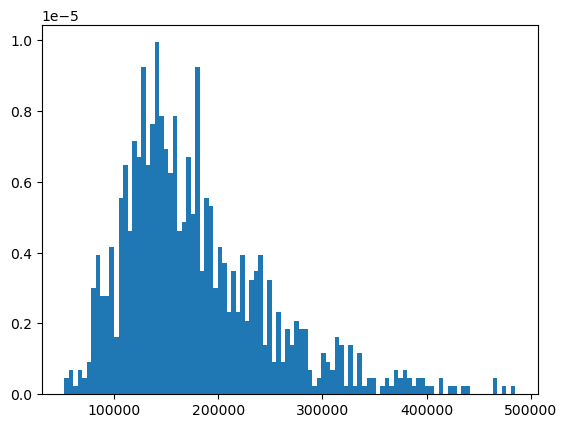

In [28]:
# looking at distribution of house prices
hist_vals = plt.hist(sale_prices, bins = 100, density=True)

In [11]:
# Calculate the histogram and fit the skewed Gaussian model
y_hist = hist_vals[0]
x_hist = hist_vals[1]
model = SkewedGaussianModel()
params = model.make_params(amplitude=1E-5, peak_center=150000, sigma=10000, gamma=0.01)
result = model.fit(y_hist, params, x=x_hist[:-1], max_nfev = 1000)

[[Model]]
    Model(skewed_gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 441
    # data points      = 100
    # variables        = 4
    chi-square         = 8.1297e-11
    reduced chi-square = 8.4684e-13
    Akaike info crit   = -2775.80824
    Bayesian info crit = -2765.38756
    R-squared          = 0.87624423
[[Variables]]
    amplitude:  0.95780491 +/- 0.03284432 (3.43%) (init = 1e-05)
    center:     97017.7007 +/- 2556.09993 (2.63%) (init = 0)
    sigma:      91363.1193 +/- 4844.28790 (5.30%) (init = 10000)
    gamma:      3.97347642 +/- 0.76566920 (19.27%) (init = 0.01)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, sigma)     = -0.6840
    C(sigma, gamma)      = +0.6445
    C(center, gamma)     = -0.5142
    C(amplitude, sigma)  = +0.4784
    C(amplitude, center) = -0.2938


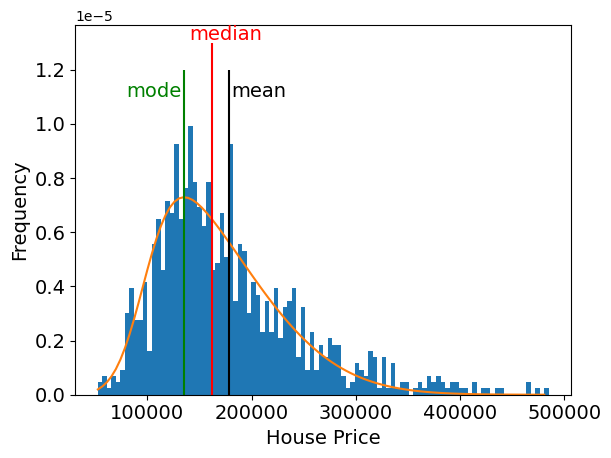

In [12]:
# Plot the histogram, best fit model, and descriptive statistics
print(result.fit_report())
plt.hist(sale_prices, bins = 100, density=True)
plt.plot(x_hist[:-1], result.best_fit)
plt.vlines(135000, 0, 1.2E-5, color = 'green')
plt.vlines(np.median(sale_prices), 0, 1.3E-5, color = 'red')
plt.vlines(np.mean(sale_prices), 0, 1.2E-5, color = 'black')
plt.text(80000, 1.1E-5, 'mode', color = 'green', fontsize = 14)
plt.text(140000, 1.31E-5, 'median', color = 'red', fontsize = 14)
plt.text(180000, 1.1E-5, 'mean', color = 'black', fontsize = 14)

# Customize the plot
plt.xlabel('House Price', fontsize = 14)
plt.ylabel('Frequency', fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14);

### EDA

In [13]:
def pieplot(df, col, df_title, lim=5, yname=None):

    '''
    This function makes a pie chart for the dataframe df
    for categorical column col only selecting top categories
    as specified by lim.
    '''

    # Grouping by the categories, counting on each categories
    # and ordering them by the count
    classes = df.groupby(col).size().reset_index(name='count').sort_values(by='count', ascending=False)

    # Take first 'lim' number of rows
    pd_df = classes[:lim]
    # Making plot
    fig, axs = plt.subplots(1, 1)
    pd_df.plot(kind='pie', x=col, y='count', title = f'{col}\n {df_title}',\
           labels=pd_df[col], legend=None, autopct='%1.1f%%', \
          explode=[j*0.1 for j in range(pd_df.shape[0])], figsize=(5,5), ax = axs)
    plt.ylabel(None)
    plt.show()

In [5]:
housing_train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
MSSubClass,1000.0,58.165000,43.579318,20.0,20.00,50.0,70.00,190.0
LotFrontage,814.0,70.120393,25.730561,21.0,59.00,70.0,80.00,313.0
LotArea,1000.0,10778.454000,11647.964726,1477.0,7559.50,9544.5,11475.75,215245.0
OverallQual,1000.0,6.088000,1.365328,1.0,5.00,6.0,7.00,10.0
OverallCond,1000.0,5.578000,1.108668,1.0,5.00,5.0,6.00,9.0
YearBuilt,1000.0,1970.550000,30.609908,1872.0,1953.00,1972.0,2000.00,2009.0
YearRemodAdd,1000.0,1984.620000,20.682296,1950.0,1966.75,1993.0,2004.00,2010.0
MasVnrArea,994.0,100.989940,169.554306,0.0,0.00,0.0,167.50,1115.0
BsmtFinSF1,1000.0,440.793000,459.445085,0.0,0.00,382.0,704.25,5644.0
BsmtFinSF2,1000.0,46.877000,163.906355,0.0,0.00,0.0,0.00,1474.0


In [6]:
categorical_columns = ['OverallQual', 'OverallCond', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'MoSold', 'YrSold']
categorical_columns += list(housing_train_data.select_dtypes(include='object').columns)

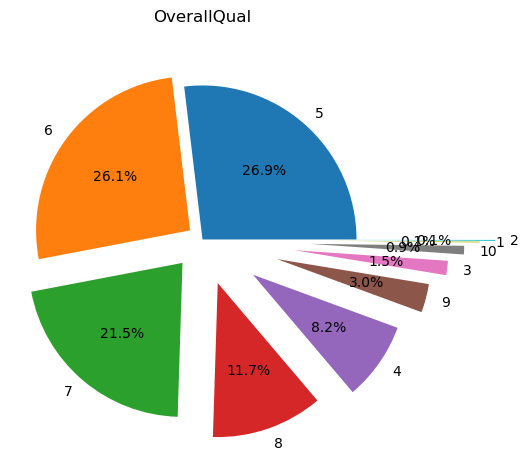

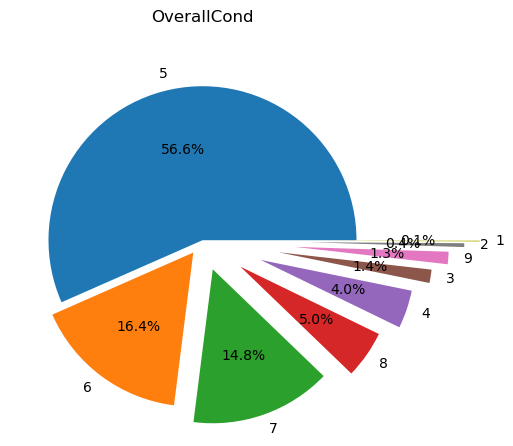

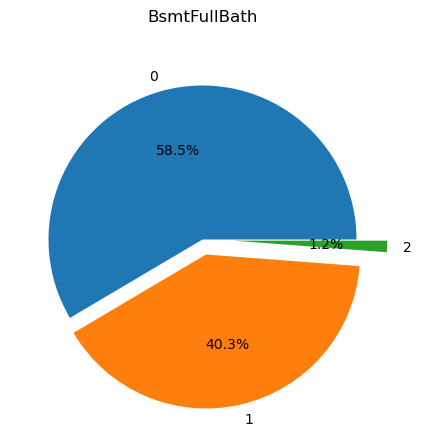

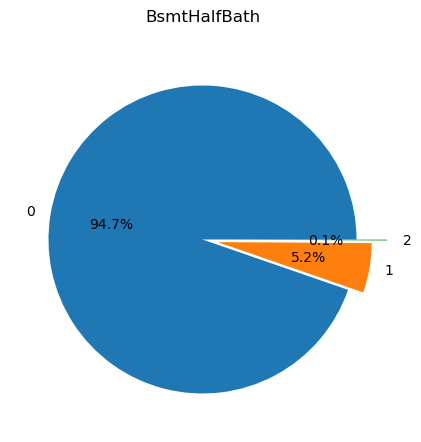

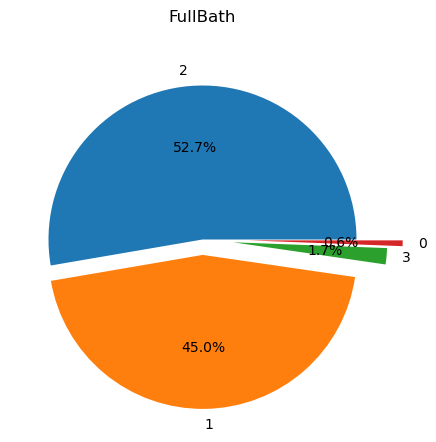

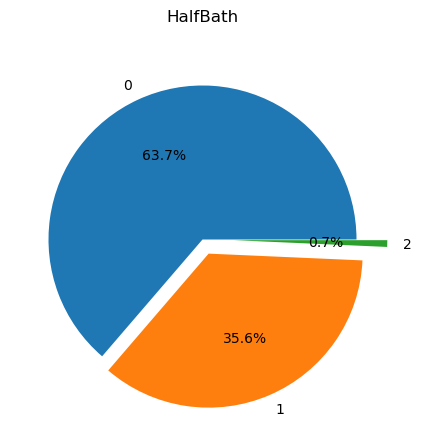

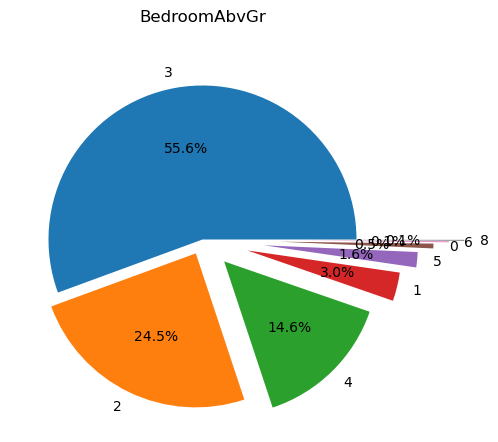

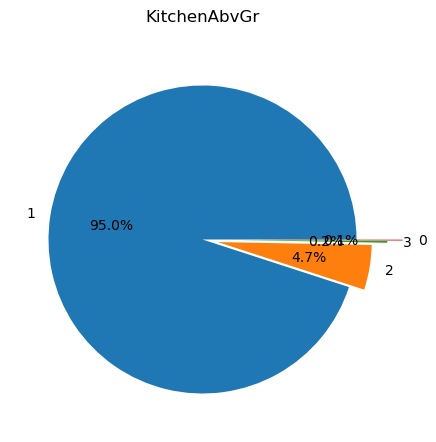

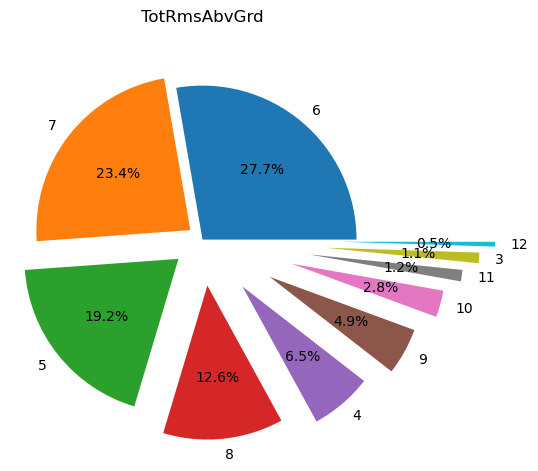

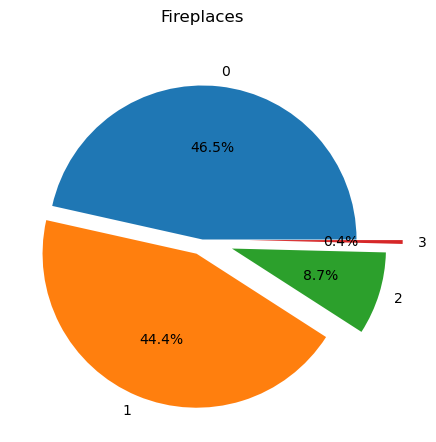

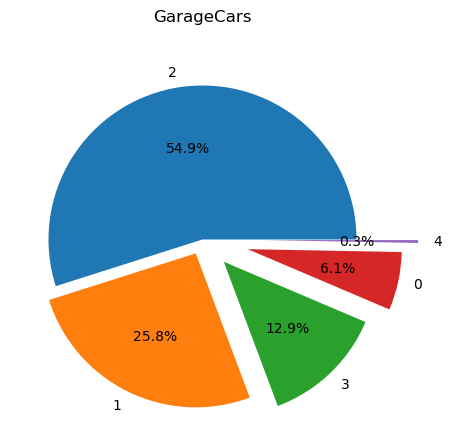

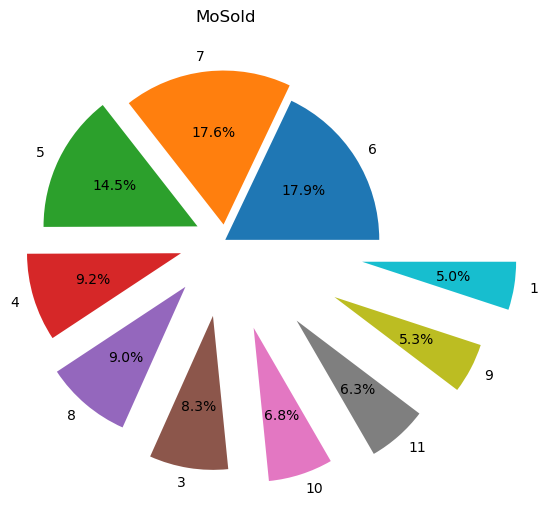

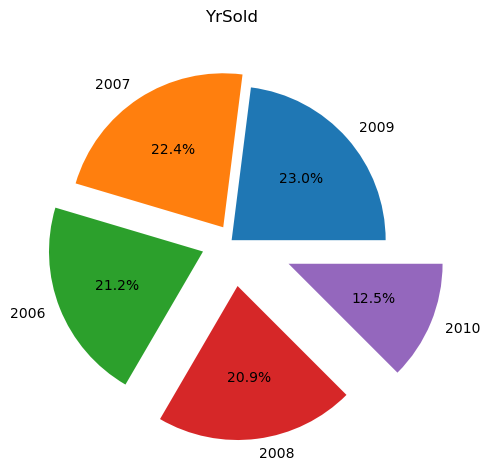

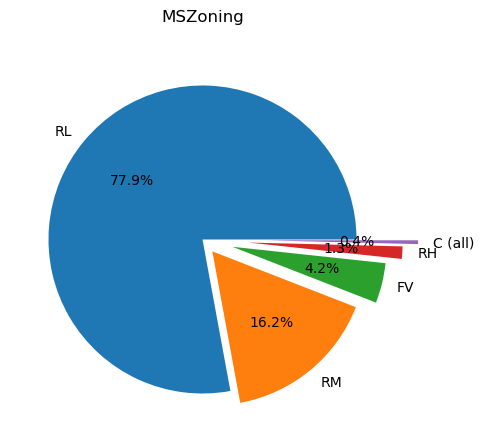

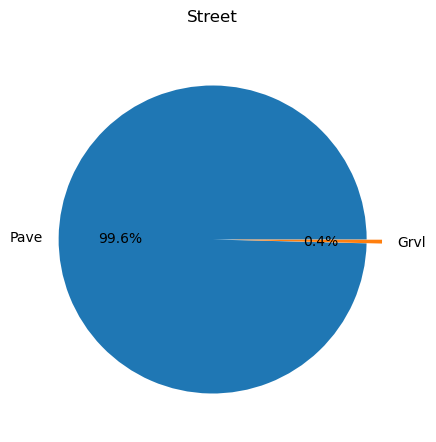

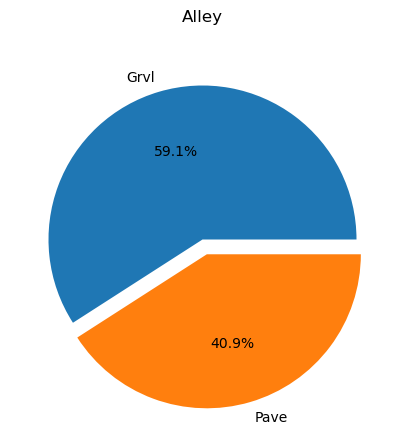

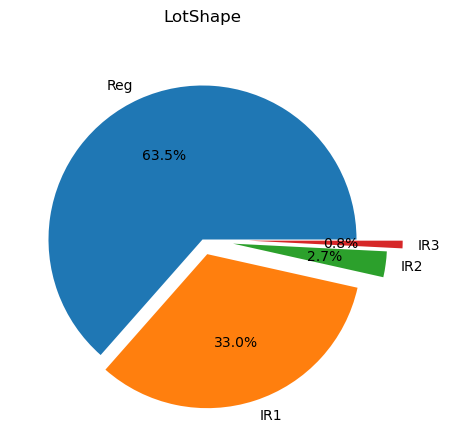

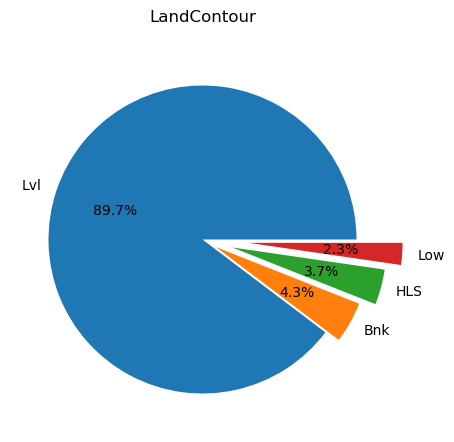

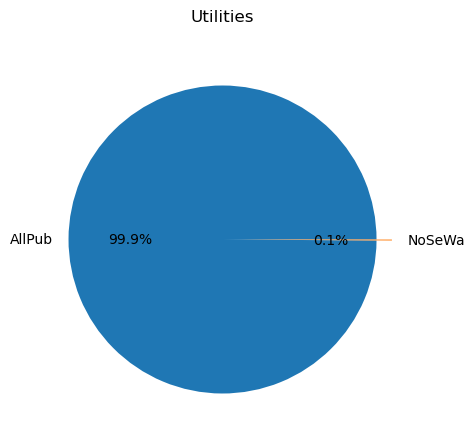

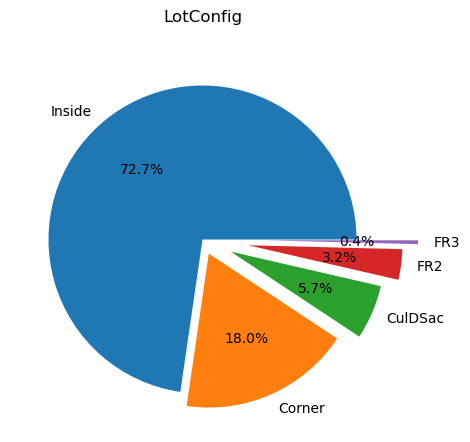

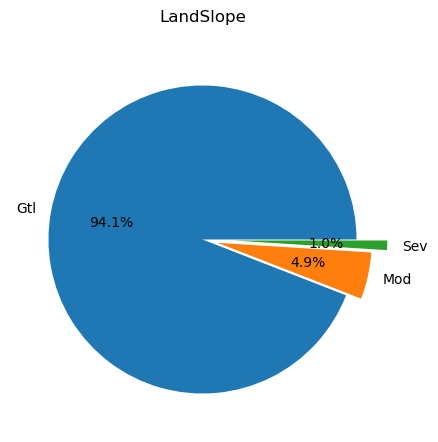

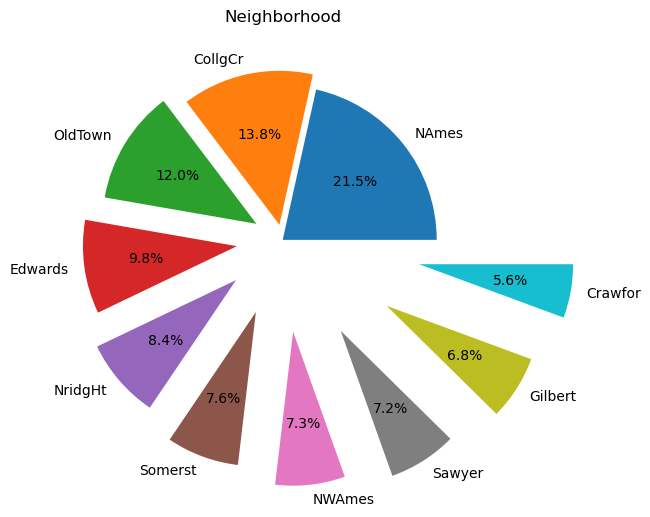

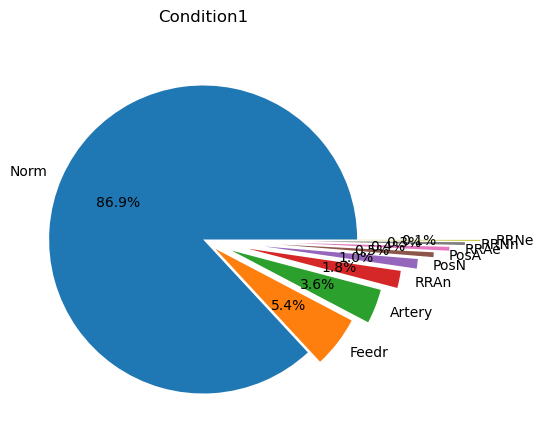

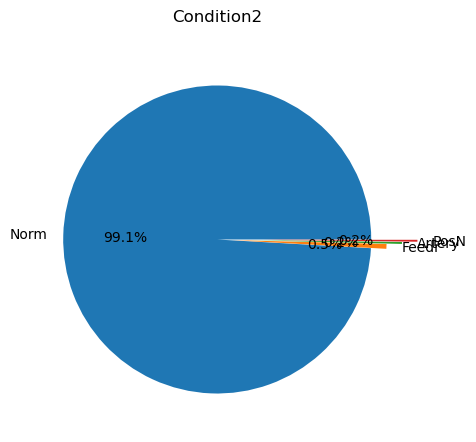

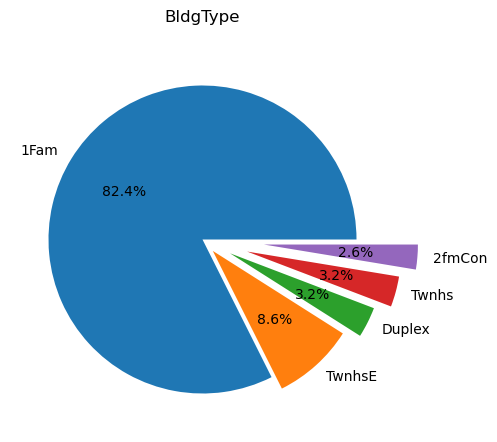

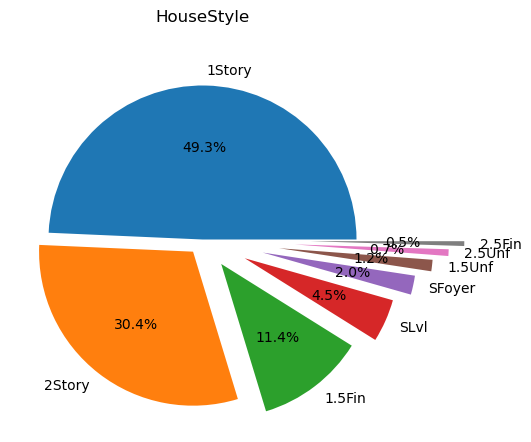

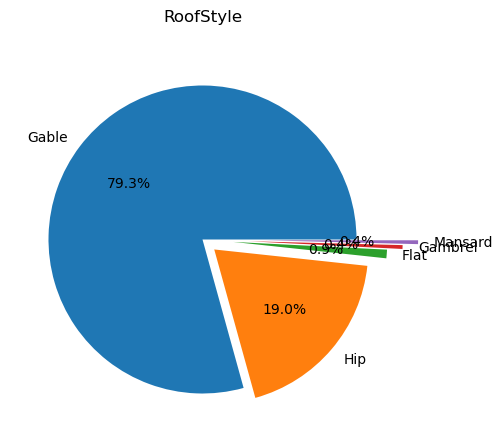

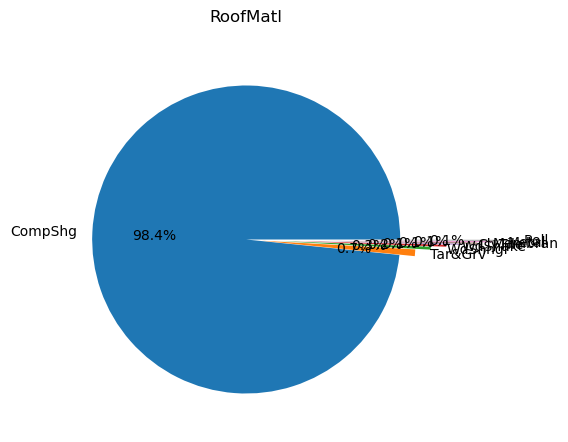

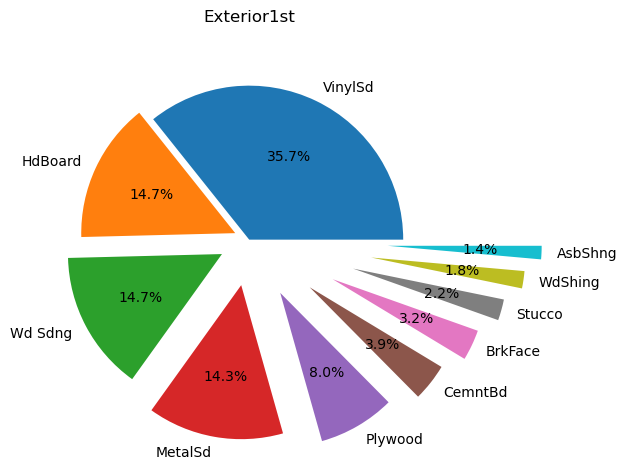

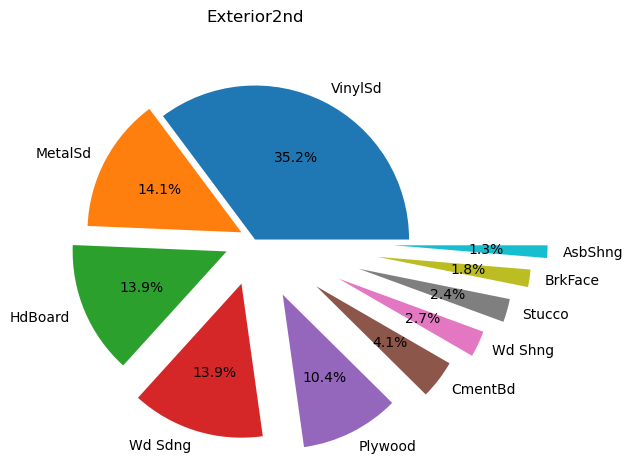

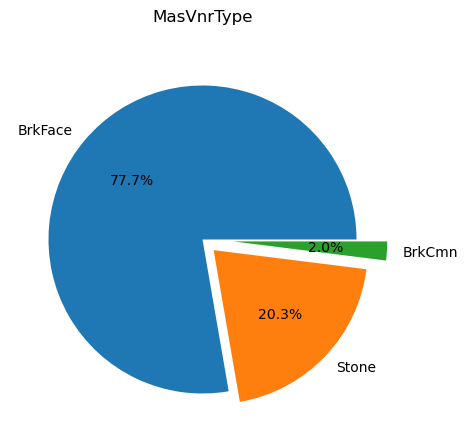

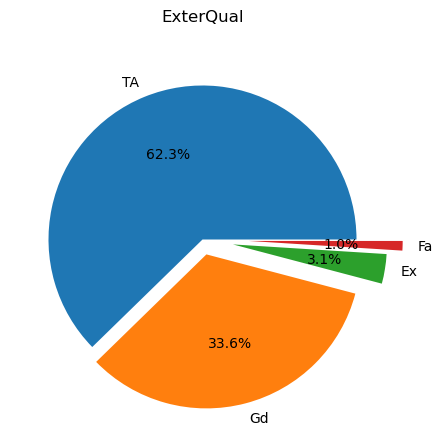

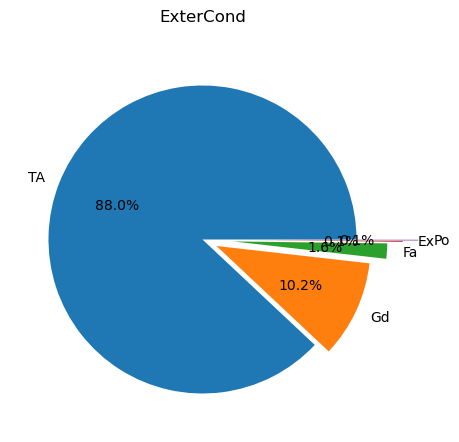

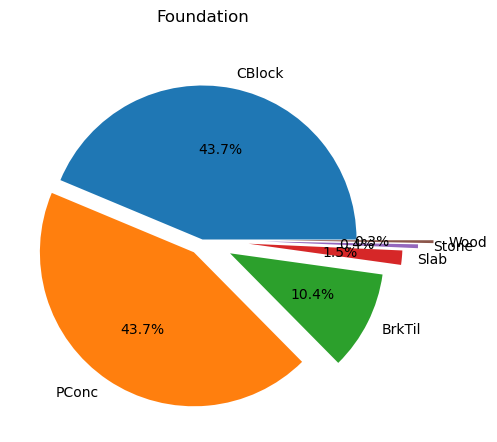

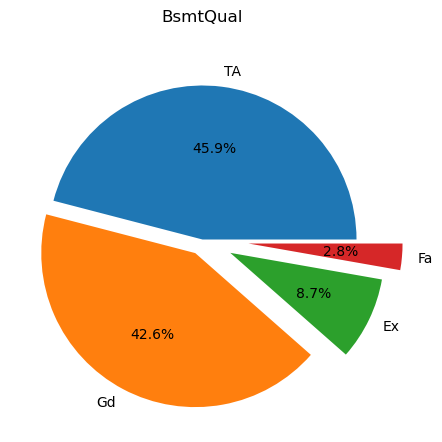

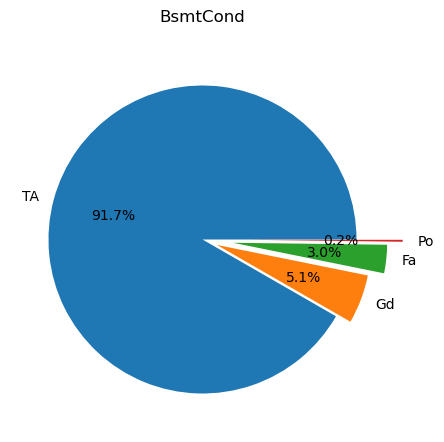

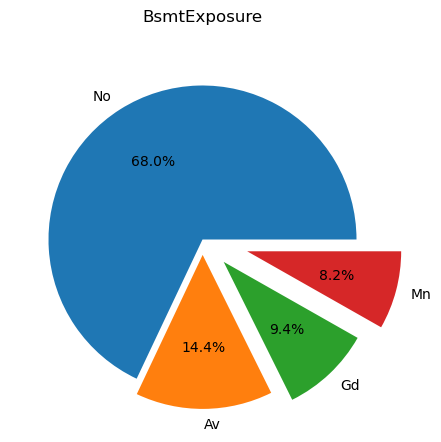

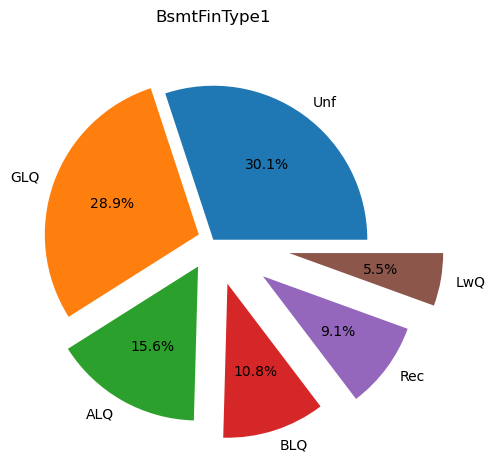

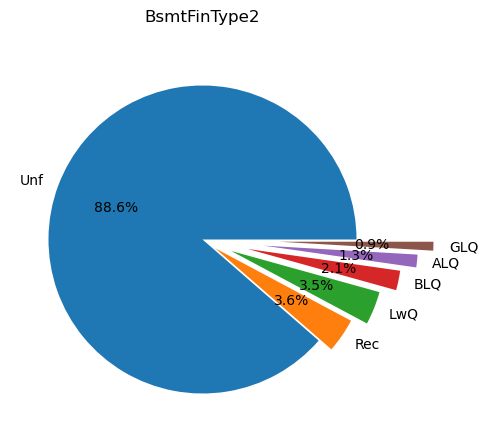

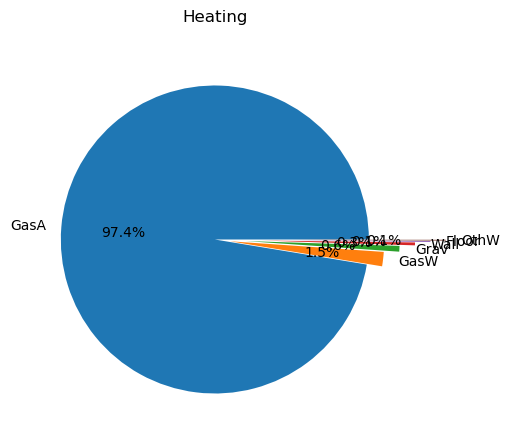

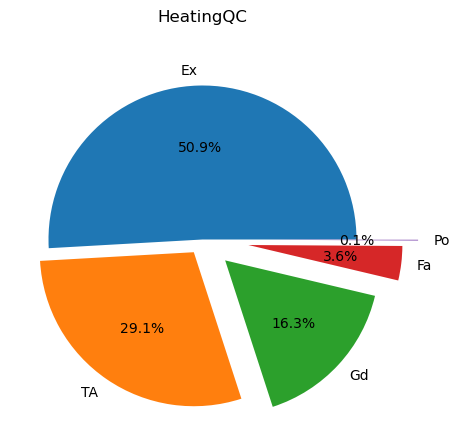

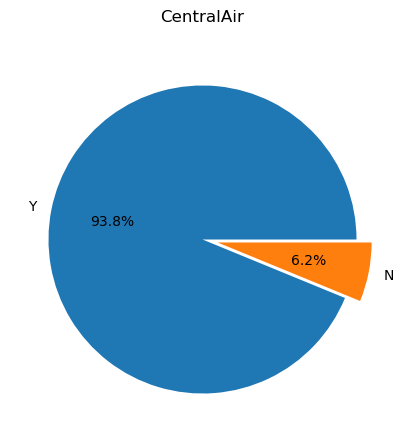

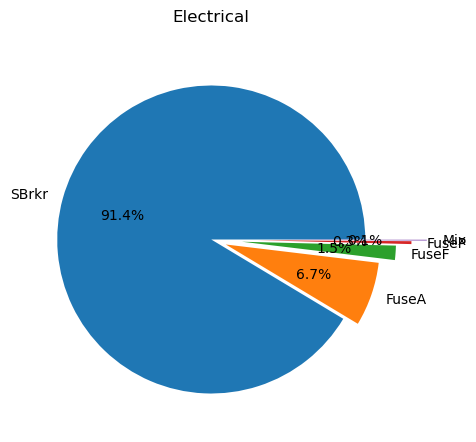

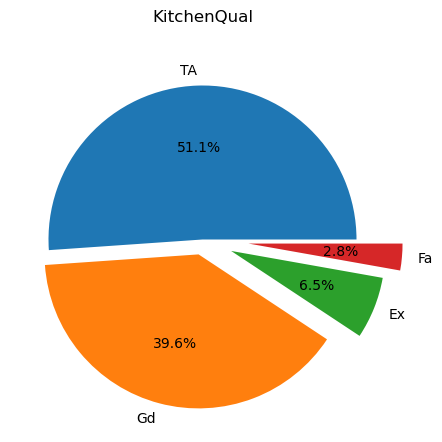

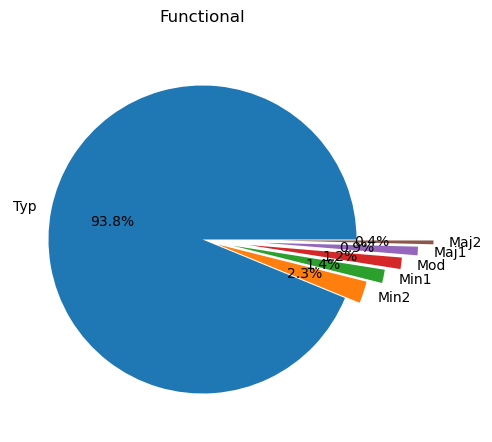

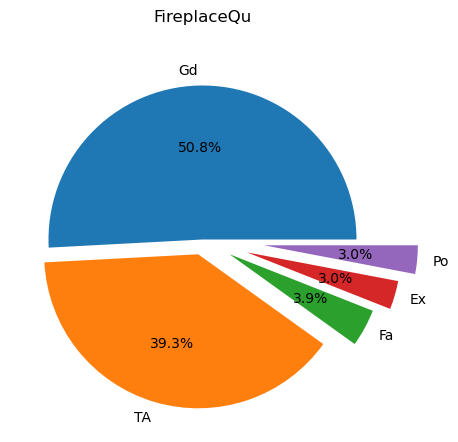

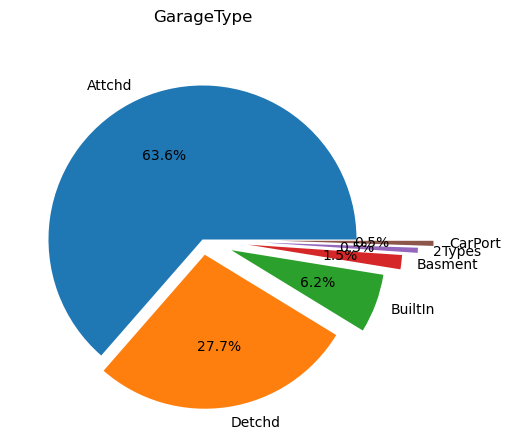

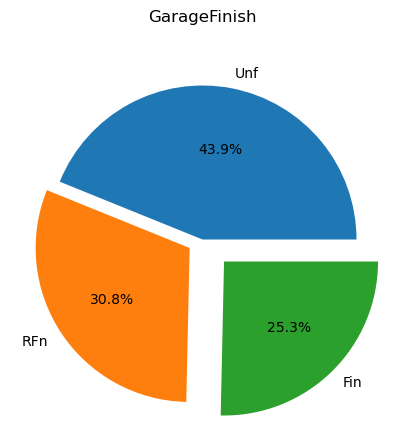

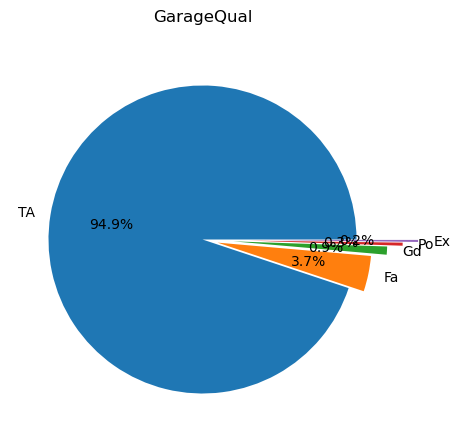

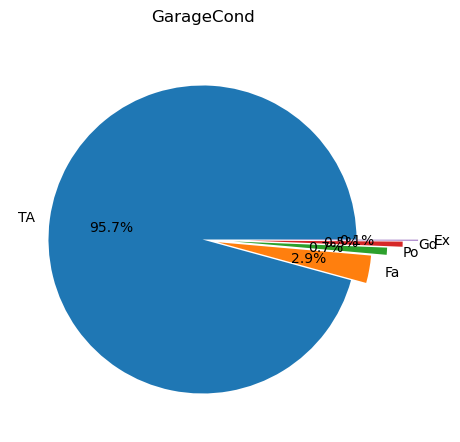

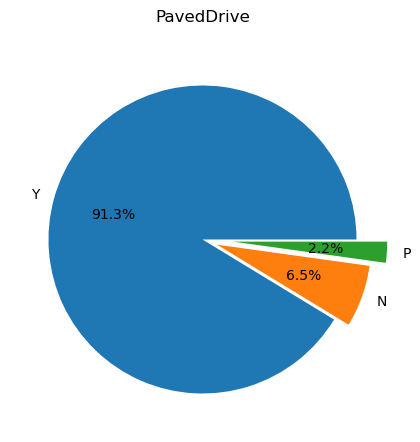

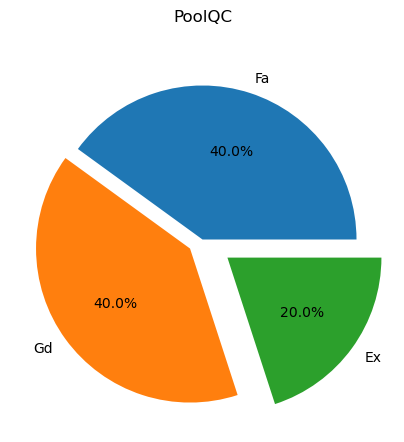

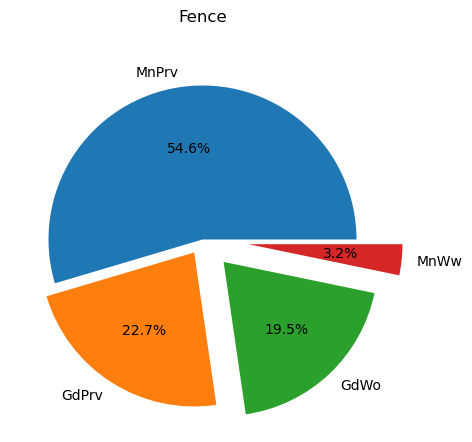

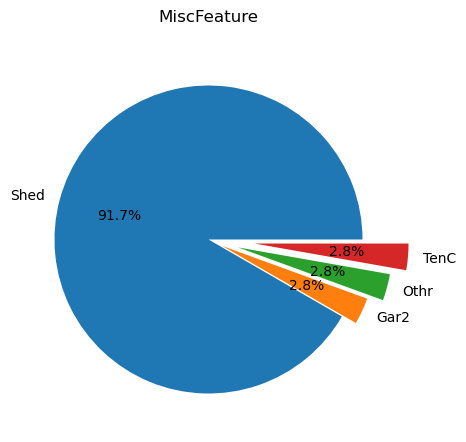

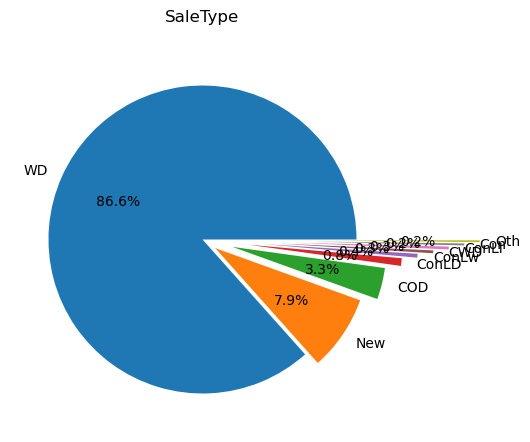

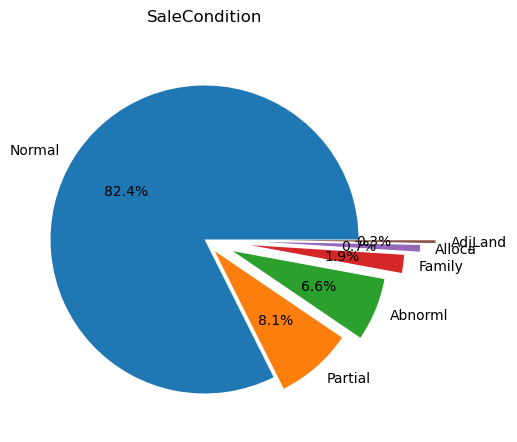

In [30]:
for col in categorical_columns:
    pieplot(housing_train_data, col, '', 10)

In [31]:
df = housing_train_data[['MoSold', 'OverallQual']]
month_df = df.groupby('MoSold').count()
month_df.head()

,OverallQual
MoSold,
1,47
2,36
3,77
4,86
5,135


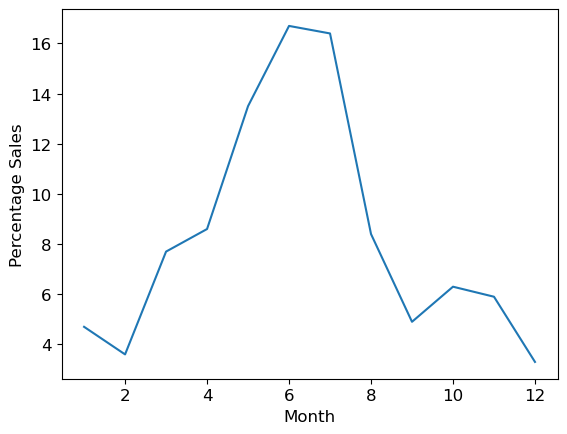

In [32]:
plt.plot(month_df.index, [ent*100/sum(month_df['OverallQual']) for ent in month_df['OverallQual']])
plt.xlabel('Month', fontsize = 12)
plt.ylabel('Percentage Sales', fontsize = 12)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.savefig('seasonality.png');

In [33]:
df = housing_train_data[['YearRemodAdd', 'SalePrice']]
year_df = df.groupby('YearRemodAdd').mean()
year_df.head()

,SalePrice
YearRemodAdd,
1950,121159.560976
1951,140000.000000
1952,124166.666667
1953,161642.857143
1954,119550.000000


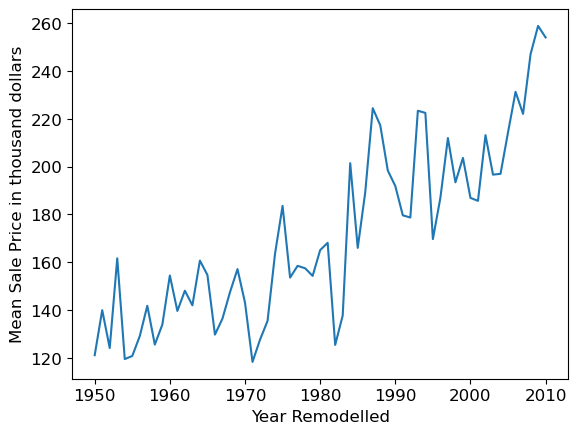

In [34]:
plt.plot(year_df.index, year_df['SalePrice']/1E3)
plt.xlabel('Year Remodelled', fontsize = 12)
plt.ylabel('Mean Sale Price in thousand dollars', fontsize = 12)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.savefig('trend.png');

In [45]:
df = housing_train_data[['YearRemodAdd', 'SalePrice', 'LotArea']]
df['price_per_sqft'] = df['SalePrice']/df['LotArea']
year_df = df.groupby('YearRemodAdd').mean()
year_df.head()

/var/folders/cy/38wjp3cx7mzffcyrq6_5r7840000gp/T/ipykernel_40683/430466352.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['price_per_sqft'] = df['SalePrice']/df['LotArea']


,SalePrice,LotArea,price_per_sqft
YearRemodAdd,,,
1950,121159.560976,9188.715447,14.885189
1951,140000.000000,13244.000000,13.139553
1952,124166.666667,8774.000000,14.636088
1953,161642.857143,12962.428571,13.069722
1954,119550.000000,10714.000000,12.162351


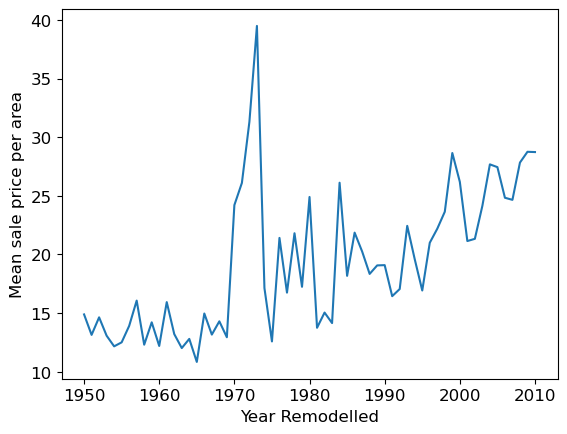

In [46]:
plt.plot(year_df.index, year_df['price_per_sqft'])
plt.xlabel('Year Remodelled', fontsize = 12)
plt.ylabel('Mean sale price per area', fontsize = 12)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.savefig('trend_per_sqft.png');

In [56]:
year_df.head(30)

,SalePrice,LotArea,price_per_sqft
YearRemodAdd,,,
1950,121159.560976,9188.715447,14.885189
1951,140000.000000,13244.000000,13.139553
1952,124166.666667,8774.000000,14.636088
1953,161642.857143,12962.428571,13.069722
1954,119550.000000,10714.000000,12.162351
1955,120833.333333,12959.333333,12.503112
1956,129168.750000,9911.625000,13.905357
1957,141816.666667,9441.666667,16.063860
1958,125600.000000,10347.692308,12.303604


In [7]:
numerical_columns = [col for col in housing_train_data.columns if col not in categorical_columns]
numerical_columns

['MSSubClass',
 'LotFrontage',
 'LotArea',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'GarageYrBlt',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal']

In [8]:
def boxplot(df, col, figsize=(5, 4)):
    '''
    This function makes a box plot for a dataframe df
    '''

    # Making plot
    df.boxplot(col, figsize=figsize)
    plt.ylabel(col)
    plt.title(None)
    plt.show()

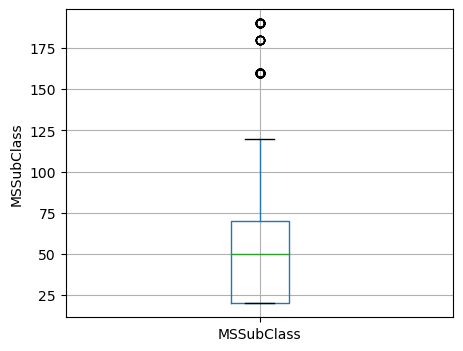

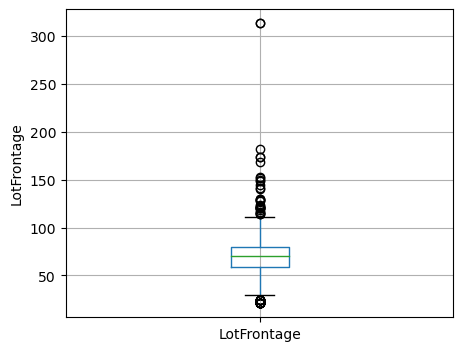

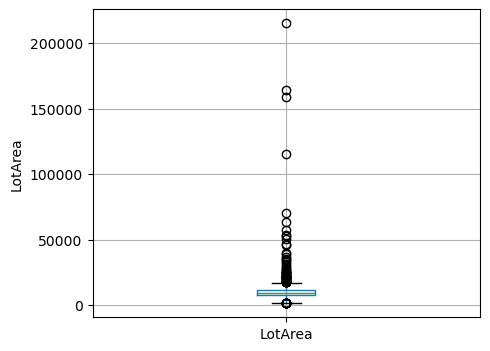

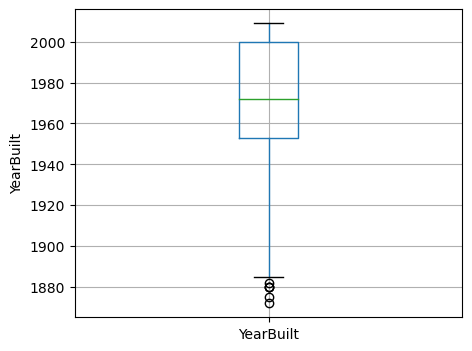

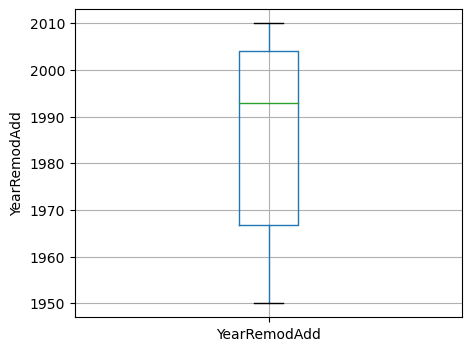

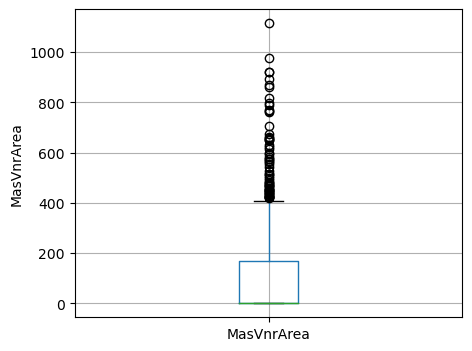

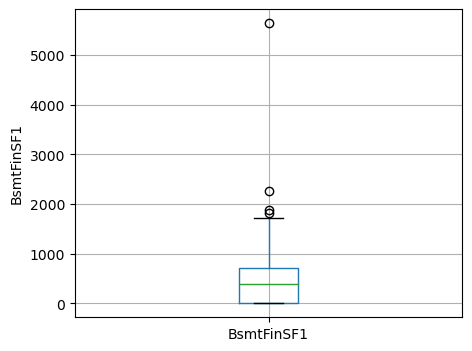

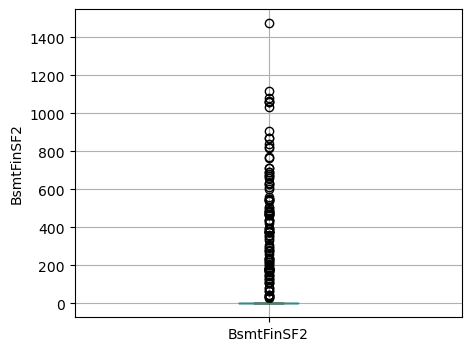

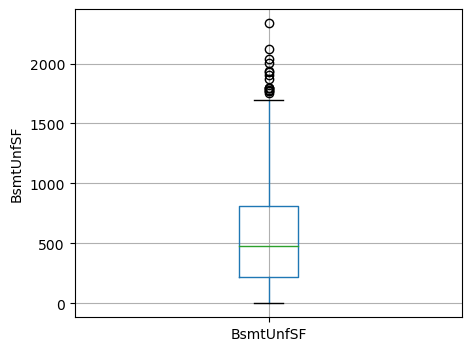

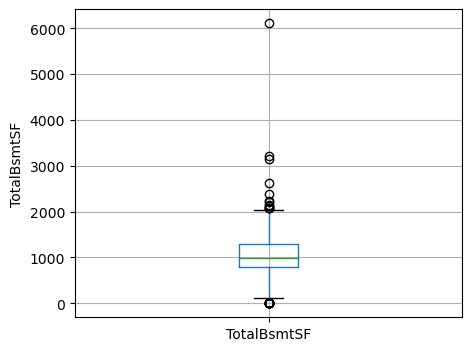

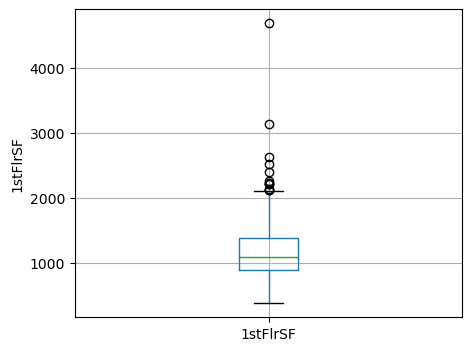

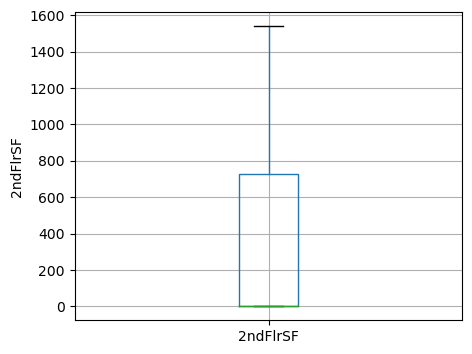

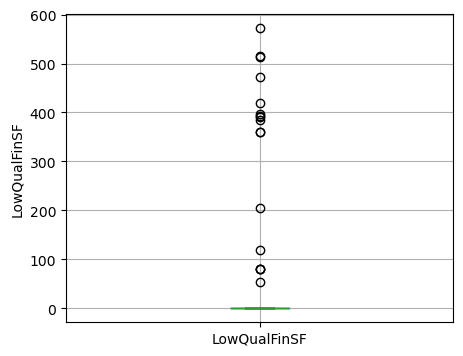

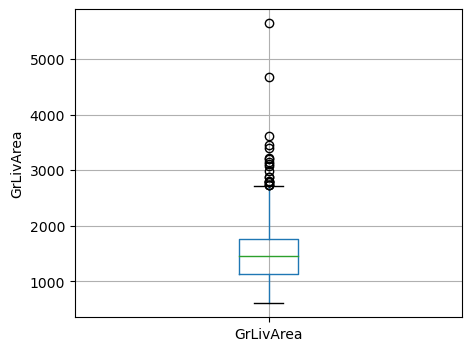

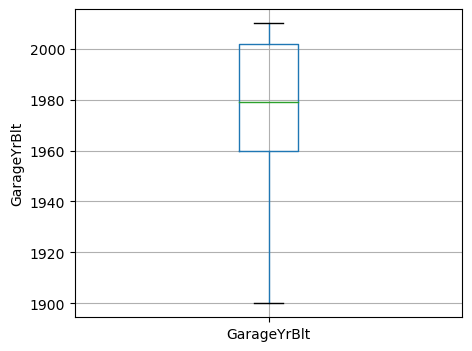

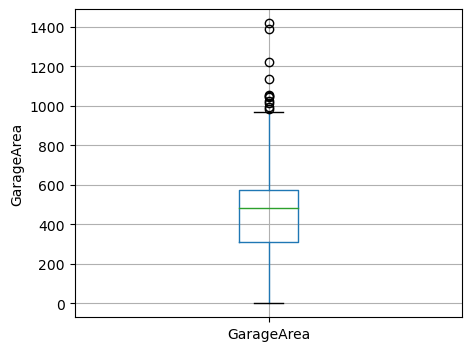

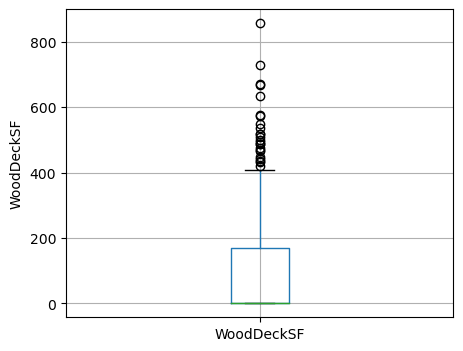

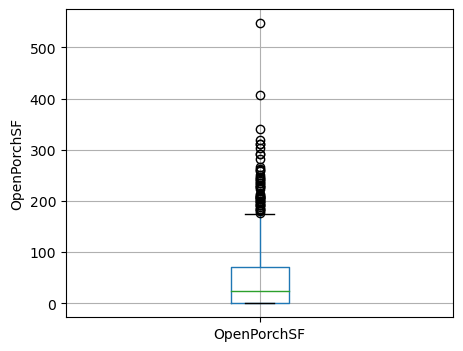

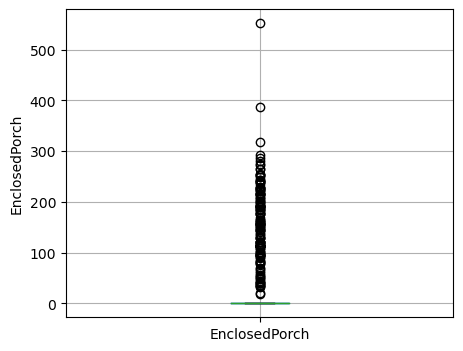

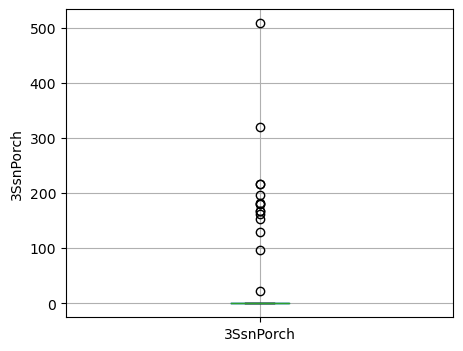

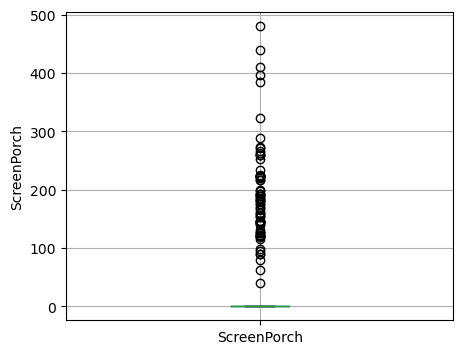

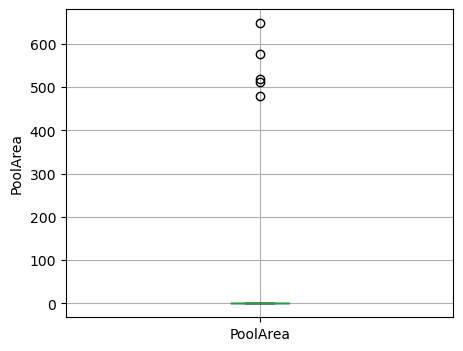

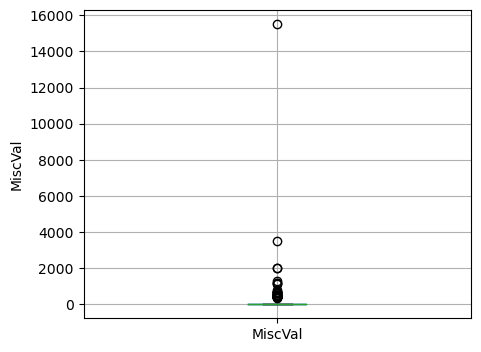

In [9]:
for col in numerical_columns:
    boxplot(housing_train_data, col)

### Imputing Missing Values

In [10]:
# Find columns with missing values
columns_with_missing_vals = []
for col in housing_train_data.columns.values:
    num_missing_vals = housing_train_data[col].isna().sum()
    if num_missing_vals > 0:
        columns_with_missing_vals.append((col, num_missing_vals))
columns_with_missing_vals = sorted(columns_with_missing_vals, key = lambda x: x[1], reverse=True)

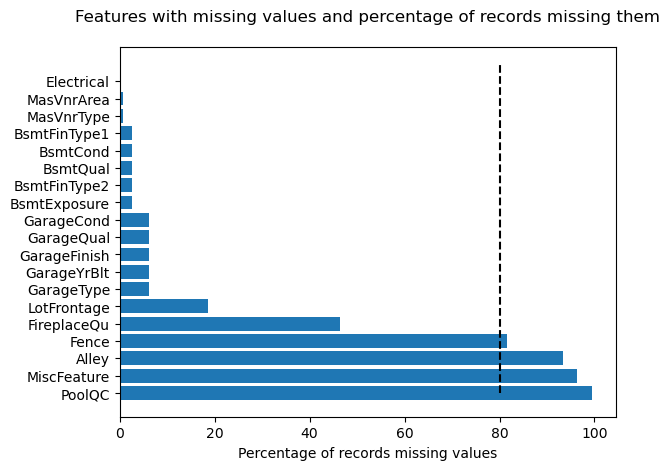

In [11]:
# Calculate the percentage of missing values for each column
columns_with_missing_vals_percentage = [100*ent[1]/housing_train_data.shape[0] for ent in columns_with_missing_vals]

# Plot a horizontal bar chart showing the percentage of missing values for each feature
plt.barh([ent[0] for ent in columns_with_missing_vals], columns_with_missing_vals_percentage)
plt.vlines(80,0,19, ls = '--', color = 'black')
plt.xlabel('Percentage of records missing values')
plt.title('Features with missing values and percentage of records missing them\n');

In [12]:
print('Number of columns with missing values: ', len(columns_with_missing_vals))

Number of columns with missing values:  19


Let's remove PoolQC, MiscFeature, Alley and Fence since more that 80% of the houses have these information missing.

In [13]:
# dropping columns with missing values
dropped_columns = ['PoolQC', 'MiscFeature', 'Alley', 'Fence']
housing_train_data.drop(columns=dropped_columns, inplace=True)
print('shape of train data: ', housing_train_data.shape)

shape of train data:  (1000, 75)


In [14]:
# rechecking columns with missing values 
columns_with_missing_vals = []

# Iterate over each column in the housing_train_data dataframe
for col in housing_train_data.columns.values:
    # Count the number of missing values in the column
    num_missing_vals = housing_train_data[col].isna().sum()
    # Check if the column has any missing values
    if num_missing_vals > 0:
        # Add the column name to the list of columns with missing values
        columns_with_missing_vals.append(col)

#### Imputing missing values

Let's replace missing values with the most frequent values for the feature

In [15]:
# replacing missing values with most frequent vlaues

# Creating an instance of SimpleImputer with the strategy of replacing missing values with the most frequent value
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent').fit(housing_train_data[columns_with_missing_vals])

# Transforming the columns with missing values using the SimpleImputer instance
arr = imp.transform(housing_train_data[columns_with_missing_vals])

# Dropping the columns with missing values from the original dataset
housing_train_data_imputed = housing_train_data.drop(columns = columns_with_missing_vals)

# Looping through the columns with missing values
for ind, col in enumerate(columns_with_missing_vals):
    # Imputer converts column values to string. Converting string to float for relevant columns
    if col in ['MasVnrArea', 'GarageYrBlt', 'LotFrontage']:
        # Converting the values to float16 and assigning them to the reduced dataset
        housing_train_data_imputed[col] = arr[:, ind].astype(np.float16)
    else:
        # Assigning the values to the reduced dataset
        housing_train_data_imputed[col] = arr[:, ind]
# Asserting the shape of the imputed dataset is same as original dataset
assert housing_train_data_imputed.shape == housing_train_data.shape

In [16]:
# making dictionary with features and the value imputed in the training dataset
imp_val_missing_col = {col:imp.statistics_[i] for i, col in enumerate(columns_with_missing_vals)}
imp_val_missing_col

{'LotFrontage': 60.0,
 'MasVnrType': 'None',
 'MasVnrArea': 0.0,
 'BsmtQual': 'TA',
 'BsmtCond': 'TA',
 'BsmtExposure': 'No',
 'BsmtFinType1': 'Unf',
 'BsmtFinType2': 'Unf',
 'Electrical': 'SBrkr',
 'FireplaceQu': 'Gd',
 'GarageType': 'Attchd',
 'GarageYrBlt': 2005.0,
 'GarageFinish': 'Unf',
 'GarageQual': 'TA',
 'GarageCond': 'TA'}

In [17]:
# Create an empty list to store columns with missing values after imputation
columns_with_missing_vals_after_imp = []

# Iterate through each column in the housing_train_data DataFrame
for col in housing_train_data.columns.values:
# Count the number of missing values in the current column
    num_missing_vals = housing_train_data_imputed[col].isna().sum()
    # If there are missing values in the column
    if num_missing_vals > 0:
        # Add the column name and number of missing values to the list
        columns_with_missing_vals_after_imp.append((col, num_missing_vals))

# Assert that there are no columns with missing values after imputation
assert columns_with_missing_vals_after_imp == []

#### Checking if a column has the same value for 95% or more houses

In [18]:
def check_repeated_value(arr):
    '''
    The function uses the Counter class to count the occurrences of each value
    in the input array. It then iterates over the keys of the col_values
    dictionary, which represent the unique values in the array.
    
    For each value, the function calculates the ratio of its occurrence to the
    total number of rows in the housing_train_data dataset. If this ratio is
    greater than 0.95 (indicating that the value is repeated more than 95% of
    the time), the function returns True.
    '''
    col_values = Counter(arr)
    for val in col_values.keys():
        if col_values[val]/housing_train_data.shape[0] > 0.95:
            return True

In [19]:
# identifying redundant columns
redundant_columns = []
for col in housing_train_data_imputed.columns.values:
    if check_repeated_value(housing_train_data_imputed[col].values):
        redundant_columns.append(col)
print('redundant columns:\n')
for col in redundant_columns:
    print(col)

redundant columns:

Street
Utilities
Condition2
RoofMatl
Heating
LowQualFinSF
3SsnPorch
PoolArea
MiscVal
GarageQual
GarageCond


In [20]:
print('number of redundant columns =', len(redundant_columns))

number of redundant columns = 11


In [21]:
# Remove redundant columns from the train data
housing_train_data_imputed.drop(columns=redundant_columns, inplace=True)
print('shape of train data:', housing_train_data_imputed.shape)

shape of train data: (1000, 64)


#### Outlier analysis

Outliers are data points that significantly deviate from the normal distribution of a dataset. They can have a significant impact on statistical analysis and machine learning models. Therefore, it is important to detect and handle outliers appropriately. In this article, we will explore a Python function that can help us identify features with outliers and handle them effectively.

**Key Concepts**
* Before we dive into the code, let's briefly discuss some key concepts related to outliers:

* Outlier Detection: The process of identifying data points that deviate significantly from the rest of the dataset. This can be done using various statistical techniques, such as z-scores, modified z-scores, or interquartile range (IQR).

* Z-Score: A statistical measure that quantifies how many standard deviations a data point is away from the mean of a distribution. It is calculated as the difference between the data point and the mean, divided by the standard deviation.

* Modified Z-Score: A variation of the z-score that is more robust to outliers. It uses the median and median absolute deviation (MAD) instead of the mean and standard deviation.

* Boxplot: A graphical representation of the distribution of a dataset. It displays the minimum, first quartile, median, third quartile, and maximum values, as well as any outliers.

In [22]:
def outlier_func(df, numerical_columns):
    '''
    This function takes two parameters - df (the housing dataset) and 
    numerical_columns (a list of numerical columns in the dataset). It 
    iterates over each numerical column and calculates the number of outliers 
    using the modified z-score method. It returns a list of tuples containing 
    the feature name and the number of outliers for each feature.
    '''
    outlier_features = []
    for feature in numerical_columns:
        outliers = po.ModifiedZscoreOutlier(df[feature].values)
        num_outliers = len(outliers)
        outlier_features.append((feature, num_outliers))
    return outlier_features

In [23]:
# Identify features with outliers
numerical_columns = housing_train_data_imputed.select_dtypes(include =['int64','float64']).columns
outlier_features = outlier_func(housing_train_data_imputed, numerical_columns)
outlier_features = sorted(outlier_features, key = lambda x: x[1], reverse = True)
print('(top outlier features, number of outliers)\n', )
for ent in outlier_features[:7]:
    print(ent)

(top outlier features, number of outliers)

('MSSubClass', 77)
('LotArea', 66)
('OpenPorchSF', 49)
('TotalBsmtSF', 37)
('GrLivArea', 20)
('TotRmsAbvGrd', 18)
('BsmtUnfSF', 15)


C:\Users\saura\anaconda3\Lib\site-packages\package_outlier\__init__.py:96: RuntimeWarning: divide by zero encountered in divide
  scores = deviation_from_med/(consistency_correction*mad)
C:\Users\saura\anaconda3\Lib\site-packages\package_outlier\__init__.py:96: RuntimeWarning: invalid value encountered in divide
  scores = deviation_from_med/(consistency_correction*mad)
C:\Users\saura\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


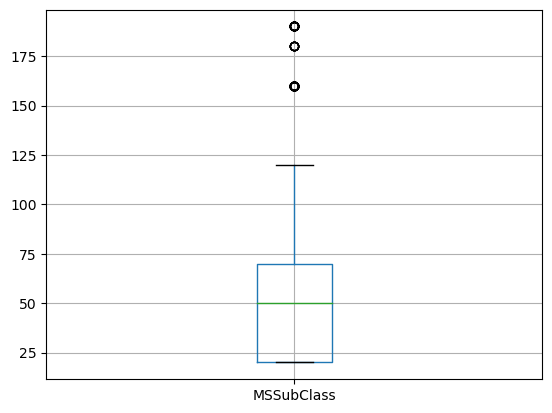

In [24]:
# let's look at box and whisker plot for features with most outliers
housing_train_data_imputed.boxplot(column = outlier_features[0][0]);

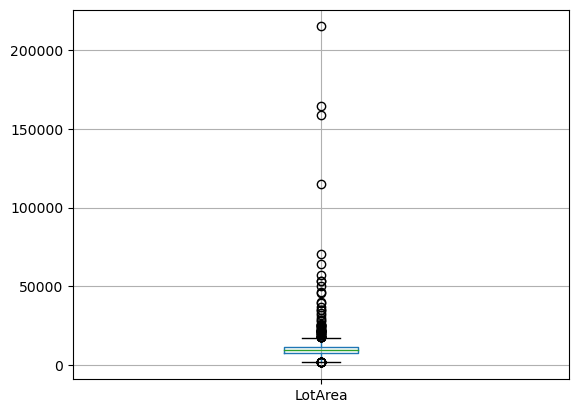

In [25]:
# Box and whisker plot for features with most outliers
housing_train_data_imputed.boxplot(column = outlier_features[1][0]);

In [26]:
# Remove records with extreme values
feature = 'LotArea'

# Set the threshold value
threshold = 100000
print('records with extreme values:')
housing_train_data_imputed[housing_train_data_imputed[feature] > threshold].sort_values(by=[feature],ascending=False)[feature]

records with extreme values:


454    215245
451    164660
524    159000
479    115149
Name: LotArea, dtype: int64

In [27]:
# Identify and remove outliers
drop_indices = housing_train_data_imputed[housing_train_data_imputed[feature] > threshold].sort_values(by=[feature],ascending=False)[feature].index.values
housing_train_data_imputed.drop(drop_indices, axis = 0, inplace = True)
sale_prices = list(pd.Series(sale_prices).drop(drop_indices).values)

# Check the shape of the dataset after removing outliers
housing_train_data_imputed.shape[0] == len(sale_prices)

True

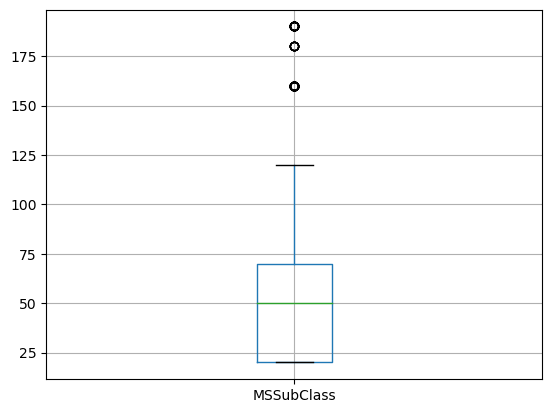

In [28]:
# rechecking for extreme outliers
housing_train_data_imputed.boxplot(column = outlier_features[0][0]);

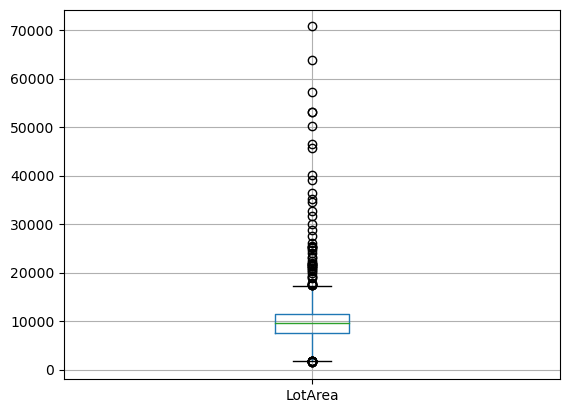

In [29]:
# rechecking for extreme outliers
housing_train_data_imputed.boxplot(column = outlier_features[1][0]);

Looks like we have removed extreme outliers. Let's move on.

### One Hot Encoding

In [29]:
# let's look at the data type of columns.
# will be useful when we want to seperate out the numerical columns for
# scaling and categorical columns for ordinal or nominal encoding.
Counter(housing_train_data_imputed.dtypes)

Counter({dtype('int64'): 29, dtype('O'): 32, dtype('float16'): 3})

In [30]:
# making list of columns containing strings/categories 
# and numerical values
string_columns = housing_train_data_imputed.select_dtypes(include='O').columns.values
numerical_columns = housing_train_data_imputed.select_dtypes(include =[np.number]).columns.values

#### Searching for ordinal columns

If categories such as 'Ex' for excellent or 'Gd' for good are present in a column, it is most likely an ordinal or ordered categorical column. For these columns, values describing excellent condition will be replaced by higher numerical value compared to bad/poor condition. 

In [31]:
# Initialize an empty list to store the ordinal variables
ordinal_variables = []
# Iterate through each column in the string_columns list
for col in string_columns:
    # Check if the column contains 'Ex' or 'Gd' which suggest that columns are ordinal
    if 'Ex' in housing_train_data_imputed[col].values or 'Gd' in housing_train_data_imputed[col].values:
        # addig column to the list of ordinal columns
        ordinal_variables.append(col)
print('ordinal columns are:\n', ordinal_variables)

ordinal columns are:
 ['ExterQual', 'ExterCond', 'HeatingQC', 'KitchenQual', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'FireplaceQu']


In [32]:
# making a dictionary to convert ordered categorical values
# such as Ex (excellent), Gd (good) into numerical values
rating_to_numerical_dict = {
'Ex': 5,
    'Gd': 4,
    'TA': 3,
    'Fa': 2,
    'Po': 1,
    'NA': 0,
    'GLQ':4,
    'ALQ':3,
    'BLQ':2,
    'Rec':3,
    'LwQ':2,
    'Unf':1,
    'Av': 3,
    'Mn': 2,
    'No': 1,
    'Fin': 3,
    'RFn': 2,
}

In [33]:
# iterating over ordinal columns
for col in ordinal_variables:
    col_values = housing_train_data_imputed[col].values
    # converting ordered categorical columns to numerical columns.
    ordinal_values = [rating_to_numerical_dict[val] if val in rating_to_numerical_dict.keys() else val for val in col_values]
    # naming the new columns by adding '_ordinal' suffix to original column names
    housing_train_data_imputed[col + '_ordinal'] = ordinal_values

In [34]:
# dropping the original ordinal columns
housing_train_data_imputed.drop(columns = ordinal_variables, inplace = True)
housing_train_data_imputed.shape

(996, 64)

#### Nominal columns

Now let's do one hot encoding on nominal columns.

In [35]:
categorical_columns = []
# iterating over all columns
for col in housing_train_data_imputed.columns:
    # checking if column is not numerical or ordinal
    if col not in numerical_columns and 'ordinal' not in col:
        # adding nominal column to list of nominal columns
        categorical_columns.append(col)
print(f'Nominal columns are:\n {categorical_columns}')

Nominal columns are:
 ['MSZoning', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'Foundation', 'CentralAir', 'Functional', 'PavedDrive', 'SaleType', 'SaleCondition', 'MasVnrType', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'GarageType', 'GarageFinish']


In [36]:
def ohe_transform_func(X):
    '''
    The function takes an input X, which represents the data to be transformed
    
    The function returns three values: 
    X_transform: which represents the transformed data, 
    X_transformer: which represents the fitted transformer object, and 
    feature_names: which returns the feature names generated by the transformer.
    '''
    # making a list of numerical columns that don't need any transformation
    numerical_columns = X.select_dtypes(include = [np.number]).columns.values
    # making a list of nominal columns that need transformation using one hot encoding technique
    categorical_columns = [col for col in X.columns.values if col not in numerical_columns]
    
    # using OHE to convert nominal values to numerical
    # dropping the first OHE column for each categorical feature because it is redundant
    ohe = OneHotEncoder(drop = 'first', handle_unknown = 'ignore')
    # creating a transformer object that performs transformations on specified columns
    features = ColumnTransformer([('categorical', ohe, categorical_columns), ('passthrough','passthrough',numerical_columns)],verbose_feature_names_out=False)
    # creating a Pipeline object that takes a transformer object as input 
    transformer = Pipeline([('features',features)])
    # fitting the transformer on the data
    X_transformer = transformer.fit(X)   
    # transforming the input data
    X_transform = X_transformer.transform(X)
    # generating new featrue names after OHE
    feature_names = transformer.named_steps['features'].get_feature_names_out()
    
    # print(transformer.get_feature_names_out)
    return X_transform, X_transformer, feature_names

In [37]:
# applying ohe on the merged train test dataset and
# returning the transformed dataset, transformer obejct and feature names
X = housing_train_data_imputed
X_transform, X_transformer, feat_names = ohe_transform_func(X)
print('shape of input data after one hot encoding: ', X_transform.shape)

shape of input data after one hot encoding:  (996, 182)


In [38]:
# Create a DataFrame to store the one hot encoded training data
transformed_train_data_df = pd.DataFrame(data = X_transform, columns = feat_names)
# Display the first few rows of the transformed training data
transformed_train_data_df.head()

,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,...,MasVnrArea,GarageYrBlt,ExterQual_ordinal,ExterCond_ordinal,HeatingQC_ordinal,KitchenQual_ordinal,BsmtQual_ordinal,BsmtCond_ordinal,BsmtExposure_ordinal,FireplaceQu_ordinal
0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,120.0,2005.0,3.0,3.0,5.0,4.0,4.0,3.0,1.0,4.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,161.0,1950.0,3.0,3.0,3.0,4.0,3.0,3.0,1.0,3.0
2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,360.0,1977.0,3.0,3.0,3.0,3.0,4.0,3.0,1.0,3.0
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1954.0,3.0,3.0,3.0,3.0,3.0,3.0,1.0,4.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,245.0,2005.0,4.0,3.0,5.0,4.0,4.0,4.0,4.0,4.0


### Train-Validation split

Let's split the data into training and hold out validation. 

In [41]:
# Create a test train split using a test size of 0.1 i.e. 10 percent of the dataset
randN = 1
y = sale_prices
X_train, X_val, y_train, y_val = train_test_split(transformed_train_data_df, y, random_state = randN, test_size = 0.1)

In [42]:
X_train.head()

,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,...,MasVnrArea,GarageYrBlt,ExterQual_ordinal,ExterCond_ordinal,HeatingQC_ordinal,KitchenQual_ordinal,BsmtQual_ordinal,BsmtCond_ordinal,BsmtExposure_ordinal,FireplaceQu_ordinal
335,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,99.0,2002.0,4.0,3.0,5.0,4.0,4.0,3.0,2.0,3.0
13,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1996.0,3.0,3.0,4.0,3.0,4.0,3.0,1.0,4.0
705,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1990.0,4.0,3.0,4.0,4.0,4.0,3.0,2.0,3.0
156,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1999.0,4.0,3.0,3.0,3.0,3.0,3.0,1.0,4.0
802,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1974.0,3.0,3.0,3.0,3.0,3.0,3.0,1.0,4.0


### Feature Selection

Some features might be highly correlated ($R^2 \ge 0.8$) and can be dropped from the training dataset.

In [43]:
# Initialize an empty list to store correlated feature pairs
correlated_pairs = []
# Calculate the correlation matrix for the normalized training data
train_set_corr_mat = X_train.corr()
print('correlated pairs of features: \n')
# Iterate over the columns of the correlation matrix
for row in train_set_corr_mat.columns.values:
    # Iterate over the columns of the correlation matrix
    for col in train_set_corr_mat.columns.values:
          # Check if the absolute value of the correlation coefficient is greater than 0.9 and the features are not the same
        if abs(train_set_corr_mat.loc[row, col] ) > 0.9 and row != col:
            print(row, col, round(train_set_corr_mat.loc[row, col], 3))
            # Add the correlated feature pair to the list
            correlated_pairs.append((row, col))

correlated pairs of features: 

RoofStyle_Gable RoofStyle_Hip -0.949
RoofStyle_Hip RoofStyle_Gable -0.949
Exterior1st_CBlock Exterior2nd_CBlock 1.0
Exterior1st_CemntBd Exterior2nd_CmentBd 0.984
Exterior1st_MetalSd Exterior2nd_MetalSd 0.986
Exterior1st_VinylSd Exterior2nd_VinylSd 0.978
Exterior2nd_CBlock Exterior1st_CBlock 1.0
Exterior2nd_CmentBd Exterior1st_CemntBd 0.984
Exterior2nd_MetalSd Exterior1st_MetalSd 0.986
Exterior2nd_VinylSd Exterior1st_VinylSd 0.978
SaleType_New SaleCondition_Partial 0.986
SaleCondition_Partial SaleType_New 0.986


In [44]:
# in the correlated features list created above, 2 highly correlated features A and B are stored as (A, B) and (B, A). Let's keep only one of those combinations.
correlated_pairs = [correlated_pairs[i] for i in range(0,len(correlated_pairs),2)]
correlated_pairs

[('RoofStyle_Gable', 'RoofStyle_Hip'),
 ('Exterior1st_CBlock', 'Exterior2nd_CBlock'),
 ('Exterior1st_MetalSd', 'Exterior2nd_MetalSd'),
 ('Exterior2nd_CBlock', 'Exterior1st_CBlock'),
 ('Exterior2nd_MetalSd', 'Exterior1st_MetalSd'),
 ('SaleType_New', 'SaleCondition_Partial')]

In [45]:
# save and display the first feature from the pair of highly correlated features
correlated_cols = [ent[0] for ent in correlated_pairs]
correlated_cols

['RoofStyle_Gable',
 'Exterior1st_CBlock',
 'Exterior1st_MetalSd',
 'Exterior2nd_CBlock',
 'Exterior2nd_MetalSd',
 'SaleType_New']

In [46]:
# dropping the highly correlated features
X_train.drop(columns=correlated_cols, inplace=True)
print('train set shape: ', X_train.shape)

train set shape:  (896, 176)


C:\Users\saura\anaconda3\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


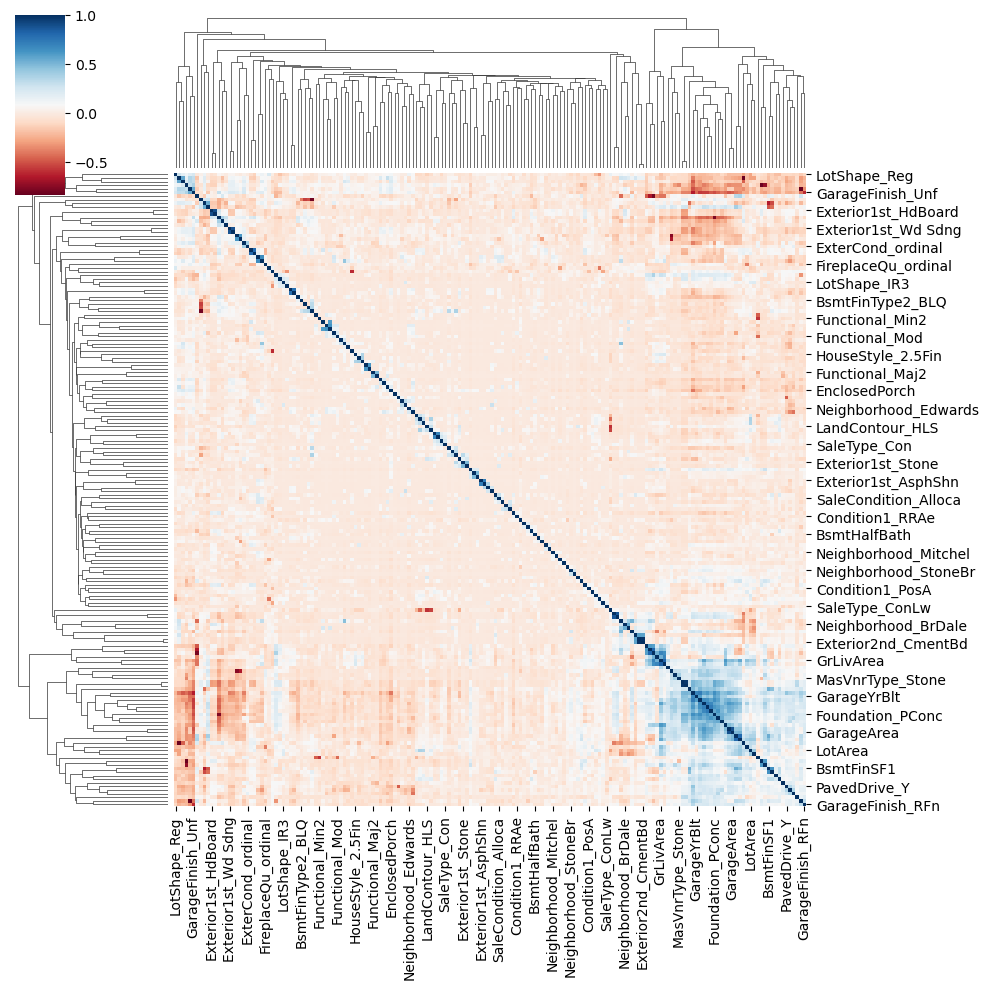

In [47]:
# displaying the clustered correlation heatmap for features
sns.clustermap(X_train.corr().fillna(value=0), cmap='RdBu');

From the plot above it looks like most of the highly correlated features (dark blue and red blocks) have been dropped successfully. We can finally move on to model building.

### Feature Scaling

Let' scale the training set and extract the scaling parameters.

In [52]:
def normalization(X):
    '''
    The function takes an input X, which represents the data to be scaled
    
    The function returns two values: 
    X_transform: which represents the scaled data, 
    X_transformer: which represents the fitted max absolute scaling transformer object, and 
    '''    
    # Define the columns that will be passed through for scaling
    passthrough_columns = X.columns.values
    features = ColumnTransformer([('passthrough','passthrough',passthrough_columns)])
    # Create a Pipeline object to chain multiple transformers together
    transformer = Pipeline([('features',features), ('scaling', MaxAbsScaler())])
    # fitting the scaling transformer on the dataset
    X_transformer = transformer.fit(X)  
    # applying the scaling on the dataset
    X_transform = X_transformer.transform(X)
       
    return X_transform, X_transformer

In [53]:
# let's normalizae the training set
X_train_norm, X_train_normalizer = normalization(X_train)
X_train_norm.shape

(896, 176)

In [54]:
# converting normalized training data matrix to dataframe
norm_X_train_data_df = pd.DataFrame(data = X_train_norm, columns = X_train.columns)
norm_X_train_data_df.head()

,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,...,MasVnrArea,GarageYrBlt,ExterQual_ordinal,ExterCond_ordinal,HeatingQC_ordinal,KitchenQual_ordinal,BsmtQual_ordinal,BsmtCond_ordinal,BsmtExposure_ordinal,FireplaceQu_ordinal
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.101538,0.996020,0.8,0.6,1.0,0.8,0.8,0.75,0.50,0.6
1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.000000,0.993035,0.6,0.6,0.8,0.6,0.8,0.75,0.25,0.8
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.000000,0.990050,0.8,0.6,0.8,0.8,0.8,0.75,0.50,0.6
3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.000000,0.994527,0.8,0.6,0.6,0.6,0.6,0.75,0.25,0.8
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.000000,0.982090,0.6,0.6,0.6,0.6,0.6,0.75,0.25,0.8


In [55]:
# asserting that the normalized dataset has the same number of columns as the ohe dataset
assert norm_X_train_data_df.shape == X_train.shape

## Model Selection and Fine Tuning

Let's try out some baseline regression models and then select the one which works the best for further fine tuning and training. The best model will be both efficient in training and highly accurate in predicting a validation dataset. 

In [56]:
# performance metric of trained models on validations sets
scoring = {'r2': 'r2',
          'mse': 'neg_mean_squared_error',
          'rmse': 'neg_root_mean_squared_error',
          }

In [57]:
def model_testing(X, y, estimators, scoring):
    '''
    The function takes in four parameters: 
    X: training features, 
    y: output column (sale price),
    estimators: the regression models that we will test, 
    scoring: performance metrics. 
    
    The function performs model testing using cross 
    validation for each estimator in the estimators dictionary. 
    
    The function returns a dictionary which contains 
    the scores for each estimator after the model testing is completed.    
    '''
    # initializing an empty disctionary that will contain the scores for each model.
    est_scores_dict = {}

    # iterating over the regressors
    for estimator in estimators.keys():
        est = estimators[estimator]
        print(f'Started with {est}\n')
        # begin counting the time it takes for 5 fold cross-validation
        start = time.time()
        # Perform cross-validation on the dataset
        est_scores_dict[estimator] = cross_validate(est, X, y, scoring = scoring);
        # stop counting after finishing cross-validation
        print(f'Finished with {est}\n')
        print('Time taken = ', round((time.time() - start)/60.,2) ,'mins \n')
        
    return est_scores_dict

In [58]:
# regression models that we'll test
estimators = {'linreg': LinearRegression(), 
             'ridge': Ridge(),
             'dtr': DecisionTreeRegressor(),
             'rfr': RandomForestRegressor(),
             'gbr': GradientBoostingRegressor(),
             'xgb': XGBRegressor(objective='reg:squarederror')}

In [60]:
# run the model testing function
est_scores_dict = model_testing(norm_X_train_data_df, y_train, estimators, scoring)

Started with LinearRegression()

Finished with LinearRegression()

Time taken =  0.0 mins 

Started with Ridge()

Finished with Ridge()

Time taken =  0.0 mins 

Started with DecisionTreeRegressor()

Finished with DecisionTreeRegressor()

Time taken =  0.0 mins 

Started with RandomForestRegressor()

Finished with RandomForestRegressor()

Time taken =  0.22 mins 

Started with GradientBoostingRegressor()

Finished with GradientBoostingRegressor()

Time taken =  0.05 mins 

Started with XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None

In [61]:
def model_score(scores_dict, scoring):
    '''
    function that calcualtes and returns the mean and standard deviation of
    the test results for each regressor as a dataframe.
    '''
    # extracting all test score metrics
    score_set = {'test_' + score for score in scoring.keys()}
    # Initialize dictionaries to store mean and standard deviation values
    mean_dict = {}
    std_dict = {}
    # Iterate over each estimator in the scores dictionary    
    for estimator in scores_dict.keys():
        # Calculate the mean value for each score 
        mean_dict[estimator] = {score: round(np.mean(scores_dict[estimator][score]),3) for score in score_set}
        # Calculate the standard deviation value for each score 
        std_dict[estimator] = {score: round(np.std(scores_dict[estimator][score]),2) for score in score_set}
    return pd.DataFrame(mean_dict), pd.DataFrame(std_dict)

In [62]:
# let's look at the cross-validation performance scores for all the regressors
mean, std = model_score(est_scores_dict, scoring)
mean

,linreg,ridge,dtr,rfr,gbr,xgb
test_rmse,-7.333289e+16,-3.138353e+04,-3.944689e+04,-2.823527e+04,-2.535458e+04,-2.798342e+04
test_r2,-2.924983e+24,8.000000e-01,6.930000e-01,8.420000e-01,8.720000e-01,8.430000e-01
test_mse,-1.684147e+34,-1.007049e+09,-1.565254e+09,-8.047627e+08,-6.499499e+08,-7.947062e+08


We see that Gradient Boost has the best validation scores. Let's pick that as our final ML model and fine-tune it.

In [63]:
# setting the parameter grid for grid search
param_grid = {'max_depth': [1,3,5,7],
             'n_estimators': [50, 100, 150],
             'learning_rate': [0.01, 0.1, 1.]} 

In [64]:
gbr = estimators['gbr']
gbr

GradientBoostingRegressor()

In [65]:
# setting up grid search cross validation
grid_search = GridSearchCV(gbr, param_grid, cv = 5, scoring = 'neg_root_mean_squared_error', n_jobs=-1)

In [66]:
start = time.time()
# performing grid search cross validation to fine tune the gradient boost model
grid_search.fit(norm_X_train_data_df, y_train);
print('Gradient Boost Grid Search Time Taken: ', round( (time.time() - start)/60., 3), ' mins')

Gradient Boost Grid Search Time Taken:  0.955  mins


In [67]:
gb_best_est = grid_search.best_estimator_
print('hyper-parameters of the best model are: ', gb_best_est)

hyper-parameters of the best model are:  GradientBoostingRegressor(n_estimators=150)


In [68]:
print('Best RMSE score =', -np.round(grid_search.best_score_))

Best RMSE score = 25111.0


### Validating the model

In [69]:
# fitting the gradient boost model
gb_best_est.fit(norm_X_train_data_df, y_train)

GradientBoostingRegressor(n_estimators=150)

In [72]:
# dropping correlated features
X_val.drop(columns=correlated_cols, inplace=True)

In [73]:
# normalizing the validation dataset
norm_X_val_data = X_train_normalizer.transform(X_val)
# converting to dataframe
norm_X_val_data_df = pd.DataFrame(data = norm_X_val_data, columns = X_val.columns)
norm_X_val_data_df.head()

,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,...,MasVnrArea,GarageYrBlt,ExterQual_ordinal,ExterCond_ordinal,HeatingQC_ordinal,KitchenQual_ordinal,BsmtQual_ordinal,BsmtCond_ordinal,BsmtExposure_ordinal,FireplaceQu_ordinal
0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.108718,0.973632,0.6,0.6,1.0,0.8,0.6,0.75,0.25,0.6
1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.252308,0.997015,0.8,0.6,1.0,0.8,0.8,0.75,0.25,0.8
2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.000000,0.970149,0.8,0.6,0.8,0.8,0.6,0.75,0.25,0.8
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.000000,0.993532,0.6,0.6,0.8,0.6,0.8,0.75,0.75,0.6
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.000000,0.997015,0.8,0.6,1.0,0.8,0.8,0.75,0.25,0.8


In [74]:
# looking at the shaoe of the validation set
norm_X_val_data_df.shape

(100, 176)

In [75]:
# predicting prices from the validation set
y_val_preds = gb_best_est.predict(norm_X_val_data_df)
rmse = mean_squared_error(y_val, y_val_preds, squared=False)

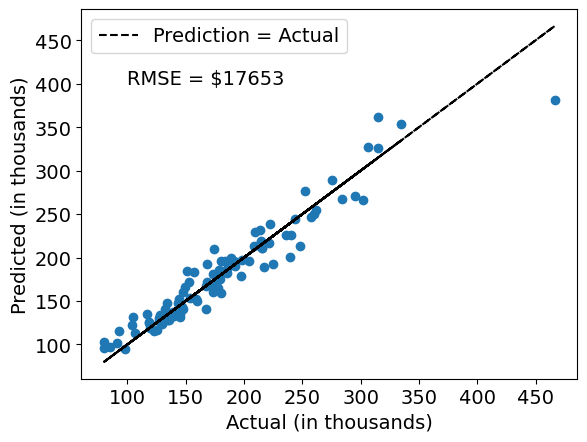

In [76]:
plt.scatter(np.array(y_val)/1000, y_val_preds/1000)
plt.plot(np.array(y_val)/1000, np.array(y_val)/1000, color = 'black', label = 'Prediction = Actual', ls='--')
plt.text(100, 400, f'RMSE = ${round(rmse)}', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Actual (in thousands)', fontsize=14)
plt.ylabel('Predicted (in thousands)', fontsize=14)
plt.legend(fontsize=14);

In [77]:
np.round(pearsonr(y_val, y_val_preds)[0]**2, 2)

0.92

## Training final model & Feature Importances

Let's train the final model on the entire dataset and understand feature importances.

In [78]:
transformed_train_data_df.drop(columns=correlated_cols, inplace=True)

In [79]:
# normalizing the validation dataset
norm_train_data = X_train_normalizer.transform(transformed_train_data_df)
# converting to dataframe
norm_train_data_df = pd.DataFrame(data = norm_train_data, columns = transformed_train_data_df.columns)
norm_train_data_df.head()

,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,...,MasVnrArea,GarageYrBlt,ExterQual_ordinal,ExterCond_ordinal,HeatingQC_ordinal,KitchenQual_ordinal,BsmtQual_ordinal,BsmtCond_ordinal,BsmtExposure_ordinal,FireplaceQu_ordinal
0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.123077,0.997512,0.6,0.6,1.0,0.8,0.8,0.75,0.25,0.8
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.165128,0.970149,0.6,0.6,0.6,0.8,0.6,0.75,0.25,0.6
2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.369231,0.983582,0.6,0.6,0.6,0.6,0.8,0.75,0.25,0.6
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.000000,0.972139,0.6,0.6,0.6,0.6,0.6,0.75,0.25,0.8
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.251282,0.997512,0.8,0.6,1.0,0.8,0.8,1.00,1.00,0.8


In [101]:
r2_scores = cross_val_score(gb_best_est, norm_train_data_df, y, cv=10, scoring = 'r2')
rmse_scores = cross_val_score(gb_best_est, norm_train_data_df, y, cv=10, scoring = 'neg_root_mean_squared_error')
print('Mean R2 = ', np.round(np.mean(r2_scores), 2), ', Std Dev R2 = ', np.round(np.std(r2_scores), 2))
print('Mean RMSE = ', np.round(abs(np.mean(rmse_scores)), 2), ', Std Dev RMSE = ', np.round(np.std(rmse_scores), 2))

Mean R2 =  0.85 , Std Dev R2 =  0.1
Mean RMSE =  25612.06 , Std Dev RMSE =  6693.28


In [94]:
# now let's train the best model on the entire train set
gb_best_est = gb_best_est.fit(norm_train_data_df, y)

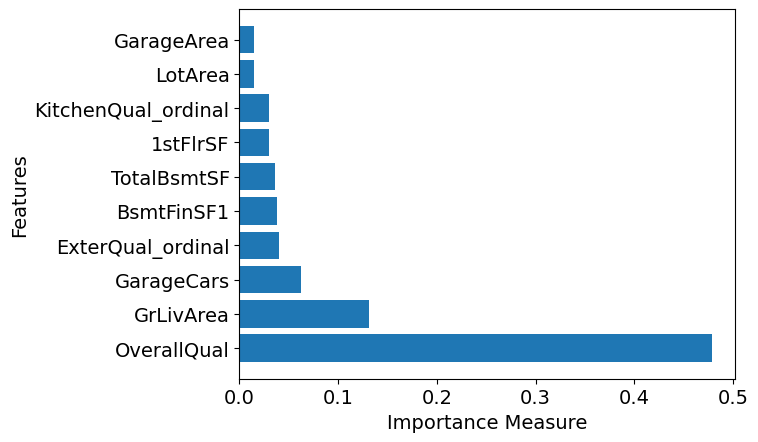

In [95]:
# for better interpretation of results, let's look at what features were important in predicting house prices

# Sort the feature importances in descending order
feature_importances = np.argsort(gb_best_est.feature_importances_)[::-1]

# Select the top 10 features
top_num_feats = 10

# Get the names of the top 10 features
top_feature_names = [gb_best_est.feature_names_in_[ind] for ind in feature_importances[:top_num_feats]]

# Get the scores of the top features
top_feature_scores = [gb_best_est.feature_importances_[ind] for ind in feature_importances[:top_num_feats]]

# Plot a horizontal bar chart to visualize the feature importances
plt.barh(top_feature_names, top_feature_scores)

# Set the x-axis label
plt.xlabel('Importance Measure', fontsize=14)

# Set the y-axis label
plt.ylabel('Features', fontsize=14)

# Set the font size of the x-axis ticks
plt.xticks(fontsize=14)

# Set the font size of the y-axis ticks and specify the labels
plt.yticks(np.arange(0,10),top_feature_names, fontsize=14);

In [96]:
# let's also look at top correlated features with sale prices

# initializing list containing R^2 scores
r2_vals = []
# iterating over features
for feature in norm_train_data_df.columns.values:
    # Calculate the Pearson correlation coefficient and p-value
    pearson_val = pearsonr(norm_train_data_df[feature],y)
    # Append the feature, r-squared value, Pearson r value, and p-value to the list
    r2_vals.append((feature, round(pearson_val[0]**2,3), round(pearson_val[0],3), pearson_val[1]))
print('(feature, r-squared value, Pearson r value, p-value)\n')
# Print the top features sorted by r-squared value in descending order
[print(ent) for ent in sorted(r2_vals, key=lambda x: x[1])[::-1][:top_num_feats]];

(feature, r-squared value, Pearson r value, p-value)

('OverallQual', 0.639, 0.8, 2.84369139184639e-222)
('ExterQual_ordinal', 0.471, 0.686, 1.2618648368704214e-139)
('KitchenQual_ordinal', 0.452, 0.672, 5.143135701008374e-132)
('GarageCars', 0.45, 0.671, 3.5423294099008645e-131)
('GrLivArea', 0.442, 0.665, 5.161109764876776e-128)
('BsmtQual_ordinal', 0.44, 0.663, 3.134972839979071e-127)
('GarageArea', 0.423, 0.651, 5.39425328172445e-121)
('1stFlrSF', 0.34, 0.583, 9.274032352629774e-92)
('TotalBsmtSF', 0.332, 0.577, 2.5486911385231248e-89)
('YearBuilt', 0.302, 0.55, 9.694291325323825e-80)


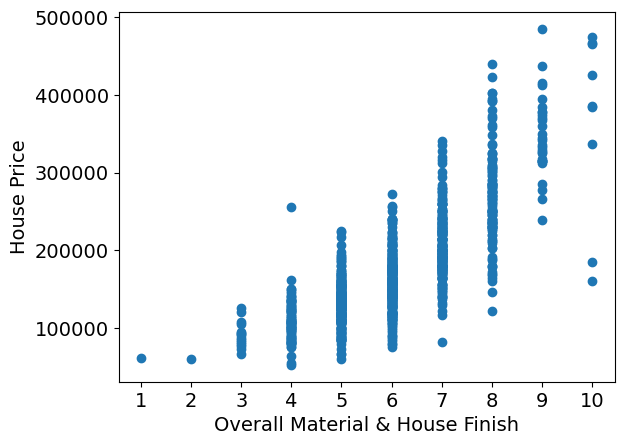

In [99]:
plt.scatter(transformed_train_data_df['OverallQual'],y)
plt.xticks(np.arange(1,11), fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Overall Material & House Finish', fontsize=14)
plt.ylabel('House Price', fontsize=14);

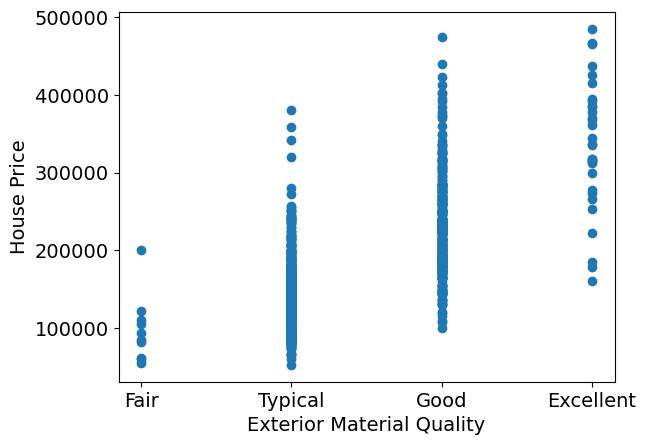

In [100]:
plt.scatter(transformed_train_data_df['ExterQual_ordinal'],y)
plt.xticks(np.arange(2,6), labels = ['Fair', 'Typical', 'Good', 'Excellent'],fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Exterior Material Quality', fontsize=14)
plt.ylabel('House Price', fontsize=14);

### Preparing Test Data

In [71]:
# First few lines of the original test set
housing_test_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
1,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml
2,90,RL,72.0,10791,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,Shed,500,10,2006,WD,Normal
3,20,RL,66.0,13695,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2008,WD,Normal
4,20,RL,70.0,7560,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,5,2009,COD,Abnorml


In [72]:
# dropping columns with more than 80% missing values in train set
housing_test_data_reduced = housing_test_data.drop(columns=dropped_columns)
print('test set shape: ', housing_test_data_reduced.shape)

test set shape:  (446, 75)


In [73]:
# imputing missing values in test set columns from parameters obtained from training set
for col in imp_val_missing_col.keys():
    housing_test_data_reduced[col].fillna(imp_val_missing_col[col], inplace=True)

In [74]:
# Remove redundant columns from the train data
housing_test_data_reduced.drop(columns=redundant_columns, inplace=True)
assert housing_test_data_reduced.shape[1] == housing_train_data_imputed.shape[1]

In [75]:
# iterating over ordinal columns in test set
for col in ordinal_variables:
    col_values = housing_test_data_reduced[col].values
    # converting ordered categorical columns to numerical columns.
    ordinal_values = [rating_to_numerical_dict[val] if val in rating_to_numerical_dict.keys() else val for val in col_values]
    # naming the new columns by adding '_ordinal' suffix to original column names
    housing_test_data_reduced[col + '_ordinal'] = ordinal_values

In [76]:
# dropping the original ordinal columns
housing_test_data_reduced.drop(columns = ordinal_variables, inplace = True)
assert housing_test_data_reduced.shape[1] == housing_train_data_imputed.shape[1]

In [77]:
# one hot encode test data and convert it to dataframe
transformed_test_data = X_transformer.transform(housing_test_data_reduced)
transformed_test_data_df = pd.DataFrame(data = transformed_test_data, columns = feat_names)
print('test set shape: ', transformed_test_data_df.shape)

test set shape:  (446, 181)


/Users/saurabh/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [9, 14] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [78]:
# normalize the test data based on parameters obtained from train set
norm_test_data = X_normalizer.transform(transformed_test_data_df)
norm_test_data_df = pd.DataFrame(data = norm_test_data, columns = feat_names)

In [79]:
norm_test_data_df.head()

,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,...,MasVnrArea,GarageYrBlt,ExterQual_ordinal,ExterCond_ordinal,HeatingQC_ordinal,KitchenQual_ordinal,BsmtQual_ordinal,BsmtCond_ordinal,BsmtExposure_ordinal,FireplaceQu_ordinal
0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.983085,0.6,0.6,1.0,0.6,0.8,0.75,1.00,0.6
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.960697,0.6,0.6,0.8,0.6,0.6,0.75,0.25,0.6
2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.978607,0.6,0.6,0.6,0.6,0.6,0.75,0.25,0.8
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.997015,0.6,0.6,1.0,0.8,0.6,0.75,0.25,0.8
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.974129,0.6,0.6,0.6,0.6,0.6,0.75,0.25,0.8


In [80]:
# dropping correlated columns
norm_test_data_df.drop(columns=correlated_cols, inplace=True)
print('train set shape: ', norm_test_data_df.shape)

train set shape:  (446, 173)


In [81]:
# asserting that the final test dataset has the same number of features as the training set
assert transformed_test_data_df.shape[1] == transformed_train_data_df.shape[1]

In [91]:
# check if final test data has any null values
transformed_test_data_df.isnull().values.any()

False

In [92]:
# predicting the house prices on the external test data
y_preds = gb_best_est.predict(norm_test_data_df)

## Demonstration of Overfitting vs Underfitting

Overfitting is a phenomena in machine learning where with increasing model complexity, the model fits very well on the training set resulting in a low bias model. On the other hand, the test or validation error increases since the model no longer generalizes to data points it hasn't "seen" or trained on before on the training set leading to a high variance model on the validation/test set. In this section, model complexity is captured by _n_estimators_ which is the number of trees used in Gradient Boosting.

One has to therefore stop training at the instance when the validation error starts increasing. That hyper-parameter combination which minimizes the validation set is considered the best combination for the estimator/model. The next step is to train the entire data set again with the best choice combination of hyper-parameters. 

In [106]:
# setting up grid search parameters
n_estimators_grid = {'n_estimators': [25, 50, 100, 150, 200, 300, 400]}

In [107]:
# setting up grid search instance with estimator and parameter grid
n_estimators_search = GridSearchCV(gbr, n_estimators_grid, cv = 5, scoring = 'neg_root_mean_squared_error', return_train_score = True, n_jobs = -1)

In [108]:
start = time.time()
n_estimators_search.fit(X_transform_train, y);
print('Gradient Boost Grid Search Time Taken: ', round( (time.time() - start)/60., 3), ' mins')

Gradient Boost Grid Search Time Taken:  0.348  mins


In [109]:
# extracting mean training scores 
mean_train_scores = n_estimators_search.cv_results_['mean_train_score']
# extracting mean validation scores 
mean_val_scores = n_estimators_search.cv_results_['mean_test_score']

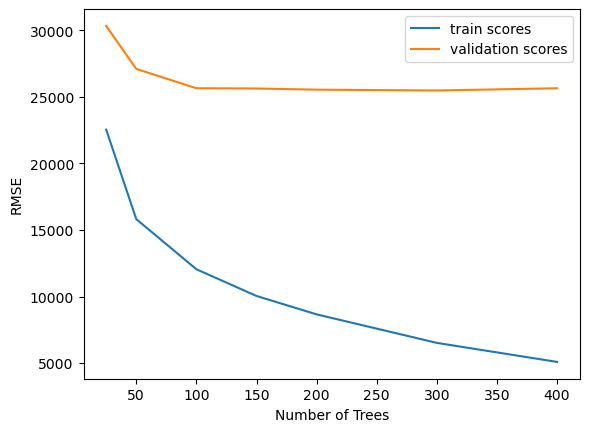

In [110]:
n_estimators_values = n_estimators_grid['n_estimators']
plt.plot(n_estimators_values, -mean_train_scores, label = 'train scores')
plt.plot(n_estimators_values, -mean_val_scores, label = 'validation scores')
plt.ylabel('RMSE')
plt.xlabel('Number of Trees')
plt.legend();

As we see, the RMSE for train set keeps decreasing with the number of trees since the more trees one uses, the prediction on train set keeps getting better. But for validation set, the RMSE decreases at first and then increases with larger values of _n_estimators_.  